# Problem Statement:

An education company named X Education sells online courses to industry professionals. On any given day, many professionals who are interested in the courses land on their website and browse for courses. 

The company markets its courses on several websites, search engines like Google, social media, referral bonus and linkedin. This is how they get leads. Through this process, some of the leads get converted while most do not. The typical lead conversion rate at X education is around 30%. 

Although X Education gets a lot of leads, its lead conversion rate is very poor. For example, if, say, they acquire 100 leads in a day, only about 30 of them are converted. To make this process more efficient, the company wishes to identify the most potential leads, also known as ‘Hot Leads’.

The company requires you to build a model wherein you need to assign a lead score to each of the leads such that the customers with a higher lead score have a higher conversion chance and the customers with a lower lead score have a lower conversion chance. 


## Structure of the solution
**1. Data Understanding** 
<br>Read dataset, inspect shape, null values and check data imbalance.
    
**2. Data Cleaning**
<br> Apply EDA process where filter null values, replace 'Select' value with NaN, compute missing values using median and mode.

**3. Univariate Analysis**
<br>Perform univariate analysis on Numerical columns, Categorical columns and summarize the observations.

**4. Bivariate Analysis**
<br>Perform bivariate analysis on Numerical columns, Categorical columns and summarize the observations.

**5. Data Preparation**
<br> Apply feature scaling, split Train dataset and Test dataset for analysis.

**6. Model Building**
<br> Build model using X_train dataset, feature selections and build model.

**7. Model Evaluation**
<br> Evaluate model using confusion matrix, finding optimal cut-off using ROC curve

**8. Prediction on Test Dataset**
<br> Apply model on the test dataset and predicting the conversion rate. 

**9. Summary**
<br> Summarize with the metrics value between Train Dataset and Test Dataset. Identify the Hot Leads.

**10. Suggestions**
<br> Action steps that the company should take on to engage with the hot leads and generate revenue for the Company.





## 0: Import libraries and implement common methods

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Used to add space after each module
def givespace():
    for i in range(10):
        print()

In [7]:
## Used to show shape of Dataframe, Data type of each column, Null percentage , unique value count of each column and unique values
def get_summary_data(df):
    print(f'Shape: {df.shape}')
    print()
    print('= '*50)

    ## calculate the null percentage of each column
    summary_dict= { 
        'column_name': df.columns,
        'data_type' : df.dtypes.values,
        'null_percentage': round(100 * df.isnull().sum()/df.shape[0], 2).values
    }
    summary_df = pd.DataFrame(summary_dict)

    ## get the categorical columns and get the unique value counts
    catg_columns = [col_name for col_name in df.columns if df[col_name].nunique() < 30]
    
    catg_data = {
        'column_name': [col_name for col_name in catg_columns],
        'unique_value_count': [df[col_name].nunique() for col_name in catg_columns],
        'value_count': [df[col_name].value_counts().to_dict().keys() for col_name in catg_columns]
    }
    
    catg_df = pd.DataFrame(catg_data)

    ## merge both summary and categorical dataframes
    final_df = pd.merge(summary_df, catg_df, how='left', on='column_name')
    return final_df
    

In [8]:
## Used to drop the columns having null percentage greater than 40% default
def drop_null_val_columns_based_on_cutoff(input_df, cut_off_val=40):
    col_to_drop = list(input_df.columns[100*input_df.isnull().mean() > cut_off_val])
    input_df.drop(col_to_drop, axis=1, inplace=True)
    return input_df

## used to retrieve the categorical columns based on the datatype
def get_categorical_columns_based_on_datatype(input_df):  
    return input_df.select_dtypes(include=['object', 'category']).columns.tolist()


## used to retrieve the numerical columns based on the datatype
def get_numerical_columns_based_on_datatype(input_df):  
    return input_df.select_dtypes(include=['int64', 'float64']).columns.tolist()


In [9]:
## used to retrieve the column names having high dominance values which does not impact to model.
## Default threshold is 95%
def get_high_dominance_columns(input_df, threshold = 0.95):  
    # Identify columns where the dominant value makes up at least 90% of the values
    columns_with_high_dominance = [
        col for col in input_df.columns
        if (input_df[col].value_counts(normalize=True).max() >= threshold)
    ]
    return columns_with_high_dominance


In [10]:
## used to merge the categorical column values having low frequency under the 'Others' Category
def merge_low_freq_multiple_catg_values(input_df, column_name):

    val_count_dict = input_df[column_name].value_counts(normalize=True).to_dict()
    
    others_column_list =[]
    
    for key in val_count_dict.keys():
        if val_count_dict[key] < 0.01:
            others_column_list.append(key)
    
    if len(others_column_list) > 1:
        for col_val in others_column_list:
            input_df[column_name] = input_df[column_name].replace(col_val, 'Others')

    return input_df


In [11]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [12]:
## Plot font dictionaries
title_dict = {'fontsize': 16, 'color':'blue', 'fontweight': 'bold',  'family': 'serif'}
label_dict = {'fontsize': 12, 'color':'darkred', 'fontweight': 'bold',  'family': 'serif'}

In [13]:
givespace()

## 1: Data Understanding

In [15]:
df = pd.read_csv('source/Leads.csv')
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [16]:
get_summary_data(df)

Shape: (9240, 37)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


,column_name,data_type,null_percentage,unique_value_count,value_count
0,Prospect ID,object,0.00,NaN,NaN
1,Lead Number,int64,0.00,NaN,NaN
2,Lead Origin,object,0.00,5.0,"(Landing Page Submission, API, Lead Add Form, ..."
3,Lead Source,object,0.39,21.0,"(Google, Direct Traffic, Olark Chat, Organic S..."
4,Do Not Email,object,0.00,2.0,"(No, Yes)"
5,Do Not Call,object,0.00,2.0,"(No, Yes)"
6,Converted,int64,0.00,2.0,"(0, 1)"
7,TotalVisits,float64,1.48,NaN,NaN
8,Total Time Spent on Website,int64,0.00,NaN,NaN
9,Page Views Per Visit,float64,1.48,NaN,NaN


### 1.1: To view the data balance

In [18]:
print(str(round(df.Converted.value_counts()[0]/len(df),2)*100) +' : '+ str(round(df.Converted.value_counts()[1]/len(df),2)*100 ))

61.0 : 39.0


### Summary overview:
From the above summary we can say
1. There are 37 columns in the dataset.
2. There are some columns with the values as 'Select'. This could be that leads are unemployed, from a different city, yet a student. So we can replace these 'Select' with 'NotSpecified' String. Along with this NaN values can be replaced with 'NotSpecified' String.
3. We can see the Target column 'Converted' has quiet balanced results. There is no data imbalance issue here.

In [20]:
givespace()

## 2: Data Cleaning

In [22]:
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,Select,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### 2.1 : Drop primary keys of dataset which we wont be using for model training

In [24]:
df.drop(['Prospect ID'], axis=1, inplace=True)
df.shape

(9240, 36)

### 2.2: Replace columns having 'Select' value with Nan. So we can compute the missing values.

In [26]:
df[df.Specialization == 'Select'].head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
4,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,Select,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified
15,660547,API,Organic Search,No,No,1,6.0,1012,6.0,Email Opened,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Select,Select,02.Medium,02.Medium,14.0,15.0,No,No,Email Opened
17,660534,API,Referral Sites,No,No,0,6.0,973,6.0,Email Link Clicked,India,Select,Select,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Might be,No,No,Select,Select,02.Medium,02.Medium,13.0,13.0,No,No,Modified


In [27]:
df = df.replace('Select', np.nan)
df.head()

,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,Specialization,How did you hear about X Education,What is your current occupation,What matters most to you in choosing a course,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,Digital Advertisement,Through Recommendations,Receive More Updates About Our Courses,Tags,Lead Quality,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Interested in other courses,Low in Relevance,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,NaN,NaN,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,NaN,No,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,Business Administration,NaN,Student,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Word Of Mouth,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Ringing,Not Sure,No,No,NaN,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,NaN,Other,Unemployed,Better Career Prospects,No,No,No,No,No,No,No,No,Will revert after reading the email,Might be,No,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


In [28]:
get_summary_data(df)

Shape: (9240, 36)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


,column_name,data_type,null_percentage,unique_value_count,value_count
0,Lead Number,int64,0.00,NaN,NaN
1,Lead Origin,object,0.00,5.0,"(Landing Page Submission, API, Lead Add Form, ..."
2,Lead Source,object,0.39,21.0,"(Google, Direct Traffic, Olark Chat, Organic S..."
3,Do Not Email,object,0.00,2.0,"(No, Yes)"
4,Do Not Call,object,0.00,2.0,"(No, Yes)"
5,Converted,int64,0.00,2.0,"(0, 1)"
6,TotalVisits,float64,1.48,NaN,NaN
7,Total Time Spent on Website,int64,0.00,NaN,NaN
8,Page Views Per Visit,float64,1.48,NaN,NaN
9,Last Activity,object,1.11,17.0,"(Email Opened, SMS Sent, Olark Chat Conversati..."


### 2.3: Drop columns having more than 40% Null values as this is not carrying much of the information

In [30]:
df = drop_null_val_columns_based_on_cutoff(df, 40)
df.shape

(9240, 29)

### 2.4: Convert 'converted' column to categories as yes/no. So it will be easy for analysis

In [32]:
df['Converted'] =  df.Converted.apply(lambda x: 'Yes' if x==1 else 'No')

In [33]:
get_summary_data(df)

Shape: (9240, 29)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


,column_name,data_type,null_percentage,unique_value_count,value_count
0,Lead Number,int64,0.00,NaN,NaN
1,Lead Origin,object,0.00,5.0,"(Landing Page Submission, API, Lead Add Form, ..."
2,Lead Source,object,0.39,21.0,"(Google, Direct Traffic, Olark Chat, Organic S..."
3,Do Not Email,object,0.00,2.0,"(No, Yes)"
4,Do Not Call,object,0.00,2.0,"(No, Yes)"
5,Converted,object,0.00,2.0,"(No, Yes)"
6,TotalVisits,float64,1.48,NaN,NaN
7,Total Time Spent on Website,int64,0.00,NaN,NaN
8,Page Views Per Visit,float64,1.48,NaN,NaN
9,Last Activity,object,1.11,17.0,"(Email Opened, SMS Sent, Olark Chat Conversati..."


### 2.5 : Compute missing column values

In [35]:
df.isnull().sum().sort_values(ascending=False)

City                                             3669
Specialization                                   3380
Tags                                             3353
What matters most to you in choosing a course    2709
What is your current occupation                  2690
Country                                          2461
TotalVisits                                       137
Page Views Per Visit                              137
Last Activity                                     103
Lead Source                                        36
Receive More Updates About Our Courses              0
Update me on Supply Chain Content                   0
Lead Number                                         0
Digital Advertisement                               0
Get updates on DM Content                           0
I agree to pay the amount through cheque            0
A free copy of Mastering The Interview              0
Through Recommendations                             0
Search                      

#### After analyzing each columns having nulls. We categorized the categorical column values (which is replaced with 'Unknown') and numerical column values having minimal null values with mean() value

In [37]:
null_catg_list = ['City', 'Specialization', 'Tags', 'What matters most to you in choosing a course', 
        'What is your current occupation', 'Country', 'Last Activity', 'Lead Source']

null_num_list =['TotalVisits', 'Page Views Per Visit']
        

In [38]:
for col_name in null_catg_list:
    df[col_name].fillna('Unknown', inplace=True)

In [39]:
for col_name in null_num_list:
    df[col_name].fillna(df[col_name].median(), inplace=True)

In [40]:
df.isnull().sum().sort_values(ascending=False)

Lead Number                                      0
Magazine                                         0
A free copy of Mastering The Interview           0
I agree to pay the amount through cheque         0
City                                             0
Get updates on DM Content                        0
Update me on Supply Chain Content                0
Tags                                             0
Receive More Updates About Our Courses           0
Through Recommendations                          0
Digital Advertisement                            0
Newspaper                                        0
X Education Forums                               0
Newspaper Article                                0
Search                                           0
Lead Origin                                      0
What matters most to you in choosing a course    0
What is your current occupation                  0
Specialization                                   0
Country                        

### 2.6 : View categorical data values which needs Data Standardization

Looks like no standardization is required as of now

In [42]:
catg_cols = get_categorical_columns_based_on_datatype(df)

for col_name in catg_cols:
    print(df[col_name].value_counts())
    print(' = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = ')

Lead Origin
Landing Page Submission    4886
API                        3580
Lead Add Form               718
Lead Import                  55
Quick Add Form                1
Name: count, dtype: int64
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
Unknown                36
bing                    6
google                  5
Click2call              4
Press_Release           2
Social Media            2
Live Chat               2
youtubechannel          1
testone                 1
Pay per Click Ads       1
welearnblog_Home        1
WeLearn                 1
blog                    1
NC_EDM                  1
Name: count, dtype: int64
 = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 
Do Not Email
No     8506
Yes     734
Name: count, dtype: int64
 = = 

In [43]:
num_cols = get_numerical_columns_based_on_datatype(df)

df[num_cols].describe()

,Lead Number,TotalVisits,Total Time Spent on Website,Page Views Per Visit
count,9240.000000,9240.000000,9240.000000,9240.000000
mean,617188.435606,3.438636,487.698268,2.357440
std,23405.995698,4.819024,548.021466,2.145781
min,579533.000000,0.000000,0.000000,0.000000
25%,596484.500000,1.000000,12.000000,1.000000
50%,615479.000000,3.000000,248.000000,2.000000
75%,637387.250000,5.000000,936.000000,3.000000
max,660737.000000,251.000000,2272.000000,55.000000


#### Looking at the numerical columns max value and 75% percentile value, there seems to be outliers present. We shall analyze further by printing the percentile till 95%

In [45]:
quantiles = [i/100 for i in range(5,100, 10)]

pd.DataFrame({
    'Quantiles' : quantiles,
    'TotalVisits': df['TotalVisits'].quantile(quantiles).values,
    'Total Time Spent on Website' : df['Total Time Spent on Website'].quantile(quantiles).values,
    'Page Views Per Visit' : df['Page Views Per Visit'].quantile(quantiles).values
})

,Quantiles,TotalVisits,Total Time Spent on Website,Page Views Per Visit
0,0.05,0.0,0.00,0.0
1,0.15,0.0,0.00,0.0
2,0.25,1.0,12.00,1.0
3,0.35,2.0,98.00,1.5
4,0.45,2.0,198.00,2.0
5,0.55,3.0,305.00,2.0
6,0.65,4.0,479.00,3.0
7,0.75,5.0,936.00,3.0
8,0.85,6.0,1233.15,4.0
9,0.95,10.0,1562.00,6.0


#### So if you compare the max value of TotalVisits and Page Views Per Visit with the 95% percentile value of respective columns, it has clearly an outliers. So we can filter those columns having less than 95% percentile

In [47]:
df = df[df['TotalVisits']<= df['TotalVisits'].quantile(0.95)]
df = df[df['Page Views Per Visit']<= df['Page Views Per Visit'].quantile(0.95)]

In [48]:
df.shape

(8611, 29)

### 2.7 Drop Tags column as it is captured by marketing team and it is not behaviour of customers

In [50]:
df = df.drop('Tags', axis=1)

In [51]:
givespace()

## 3. Univariate Analysis

### 3.1: Univariate Categorical Column Analysis 

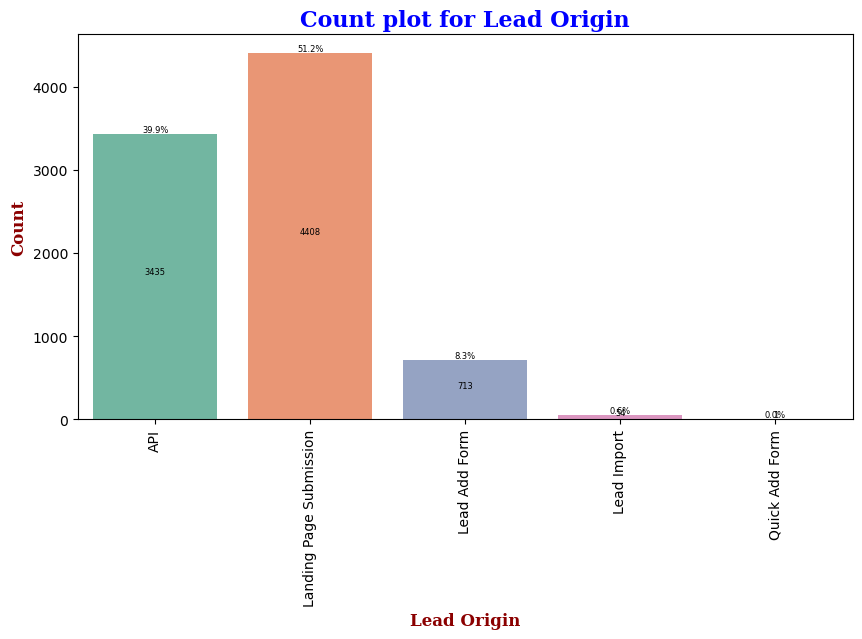

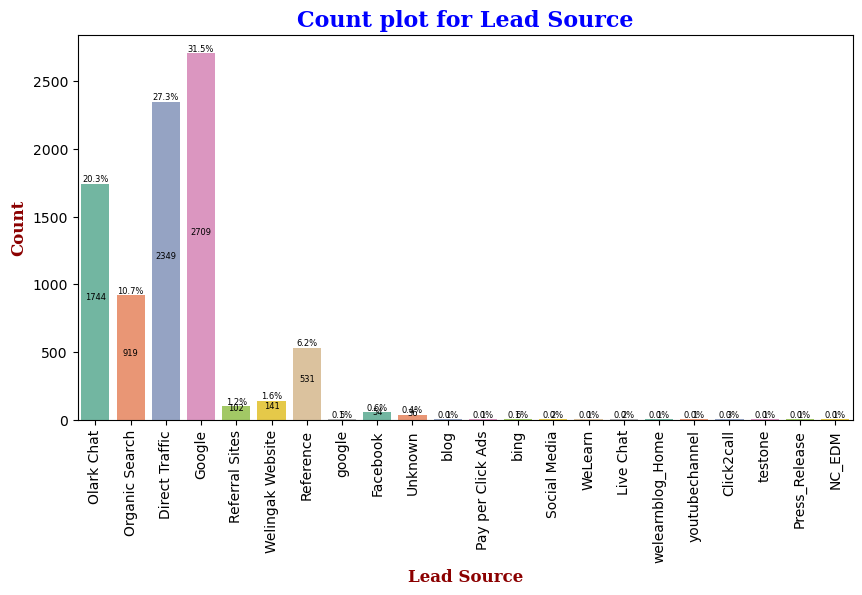

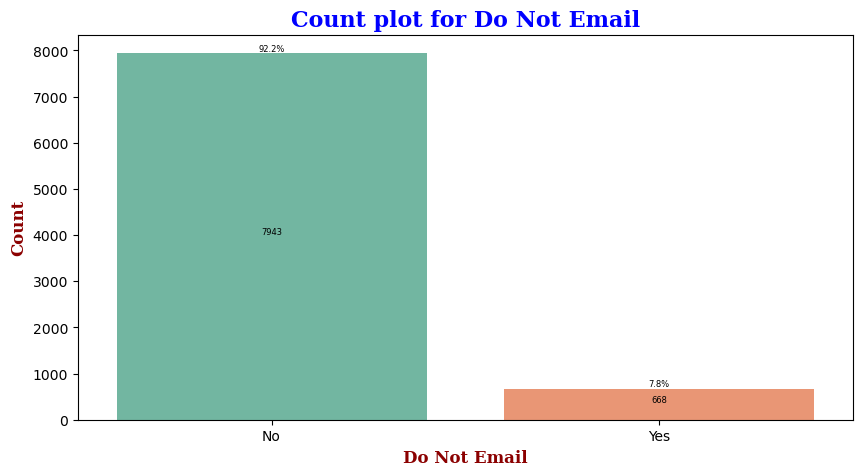

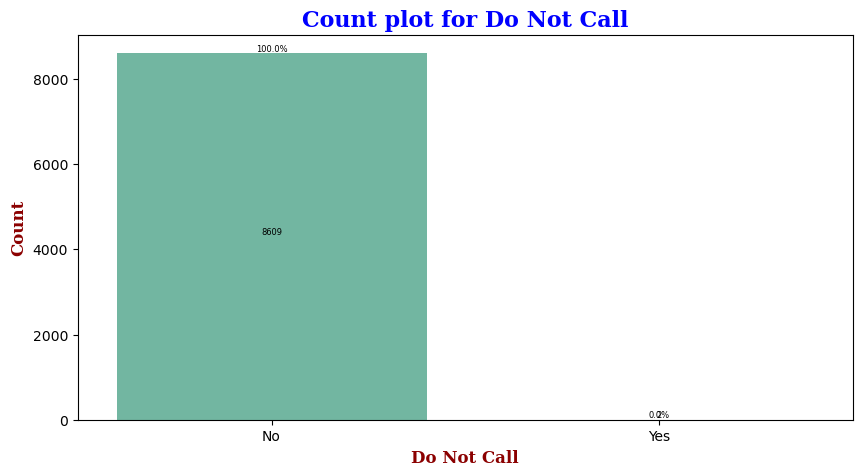

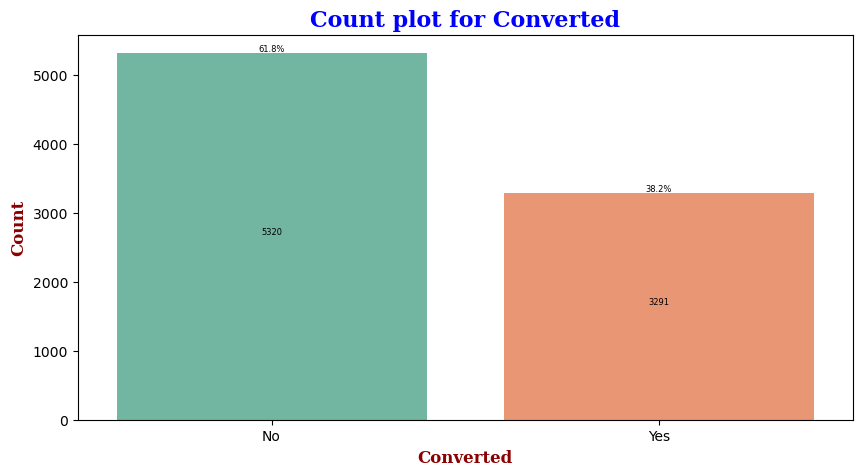

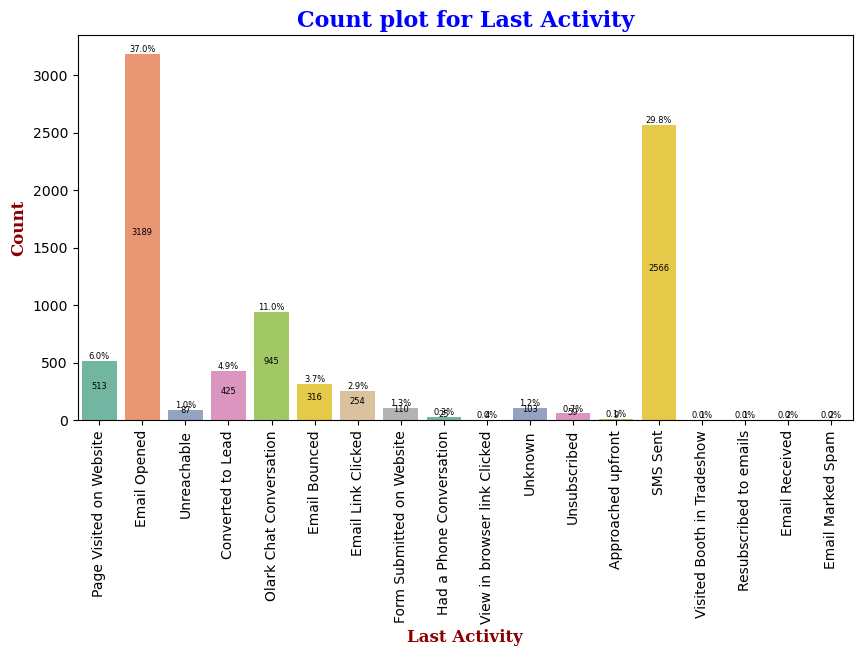

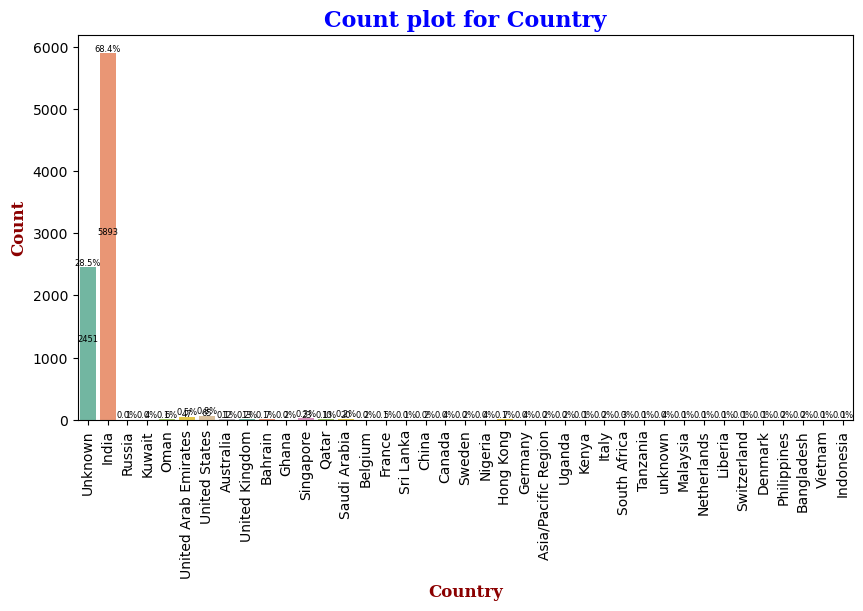

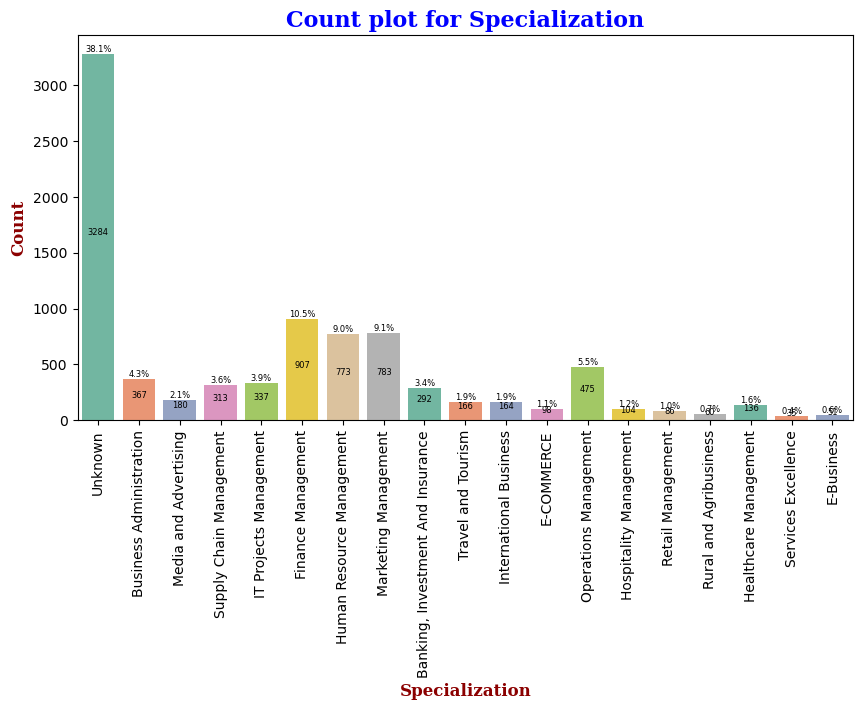

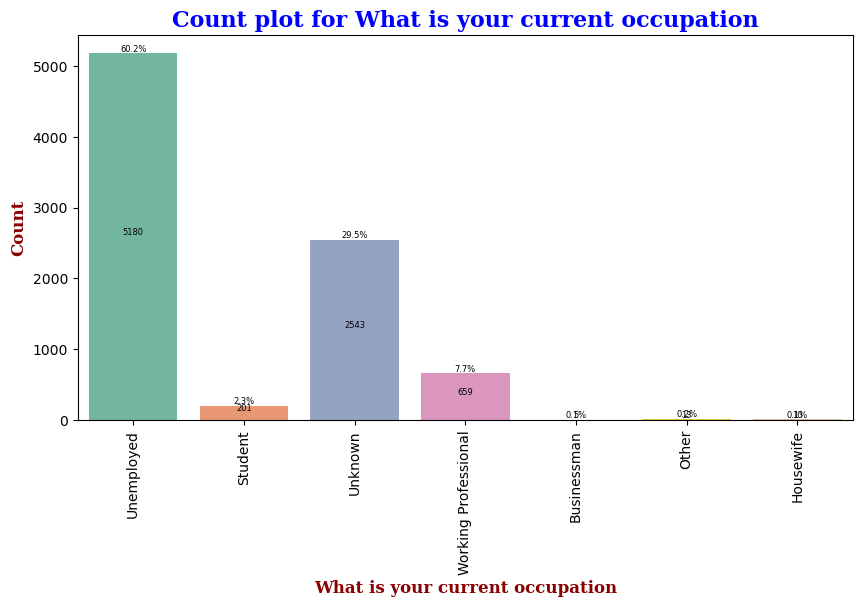

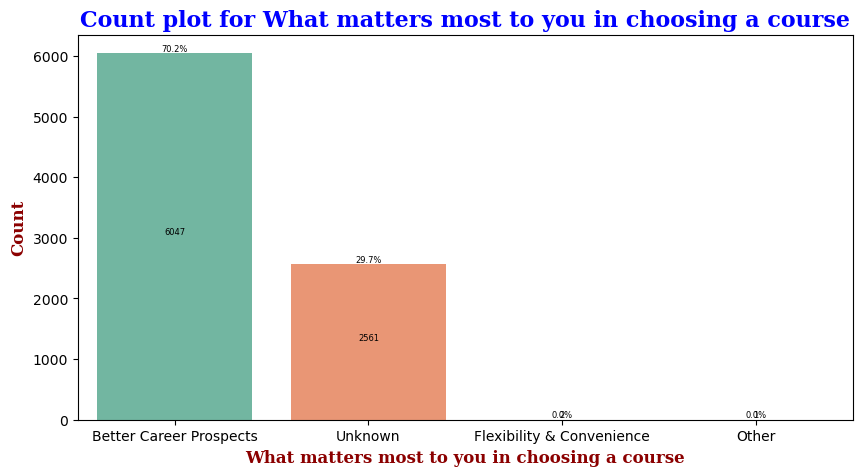

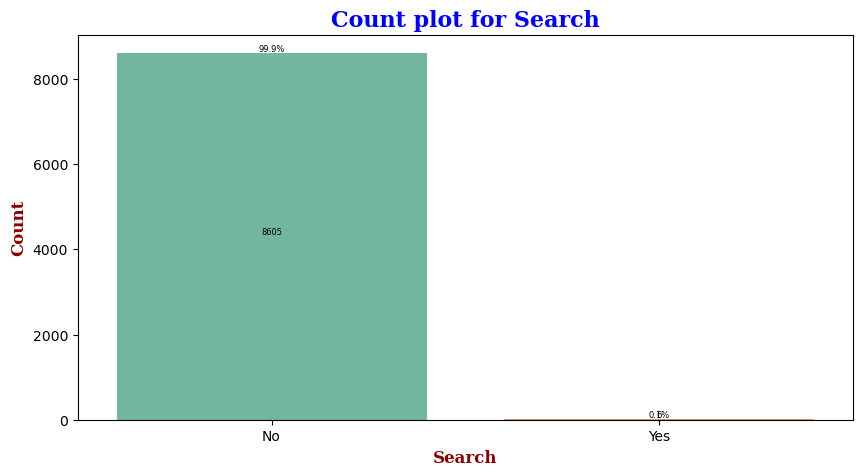

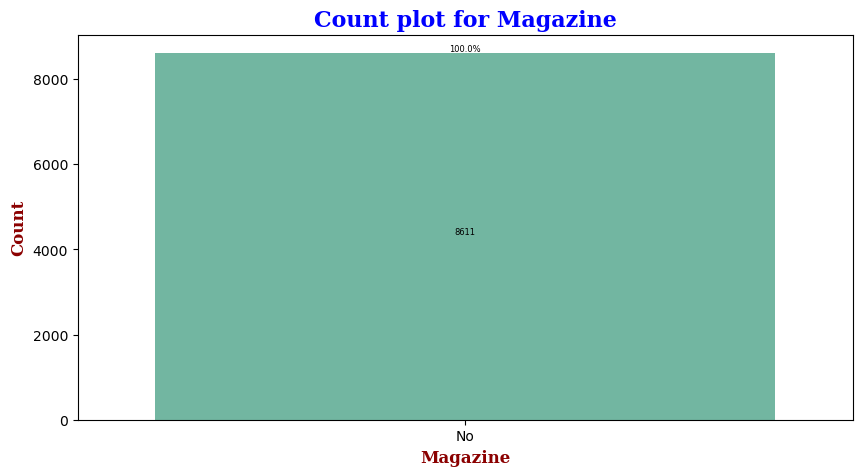

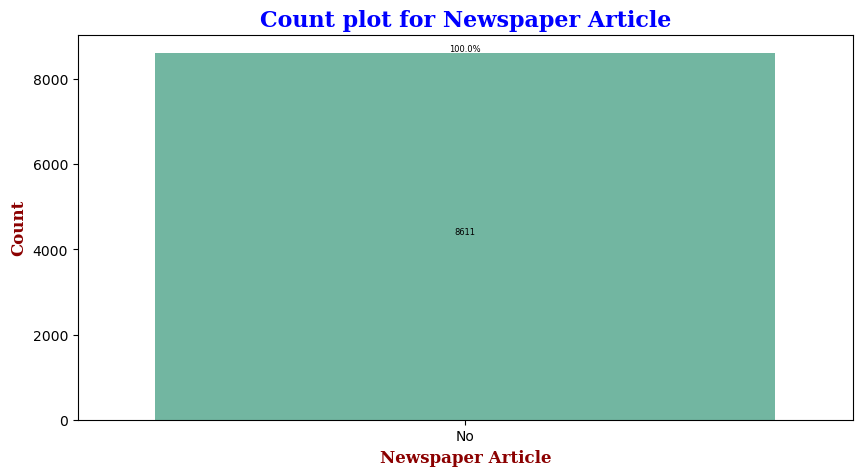

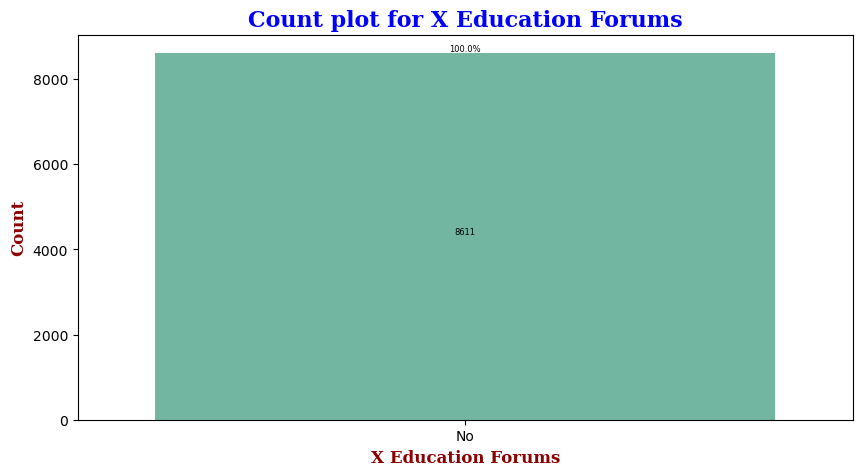

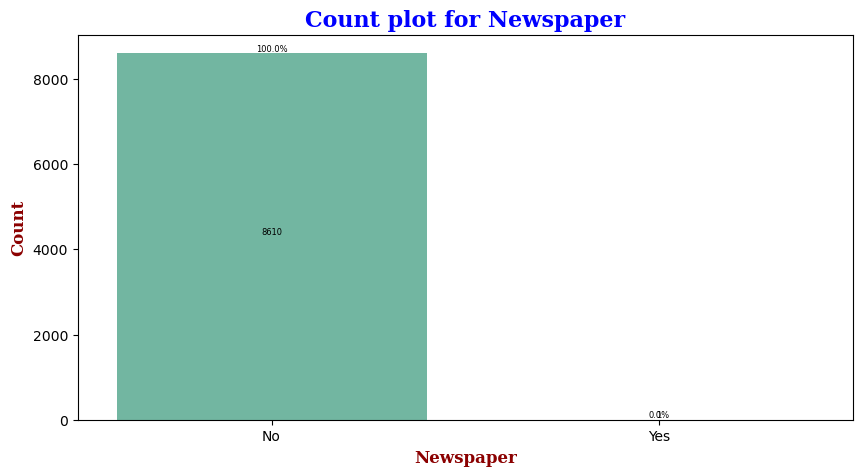

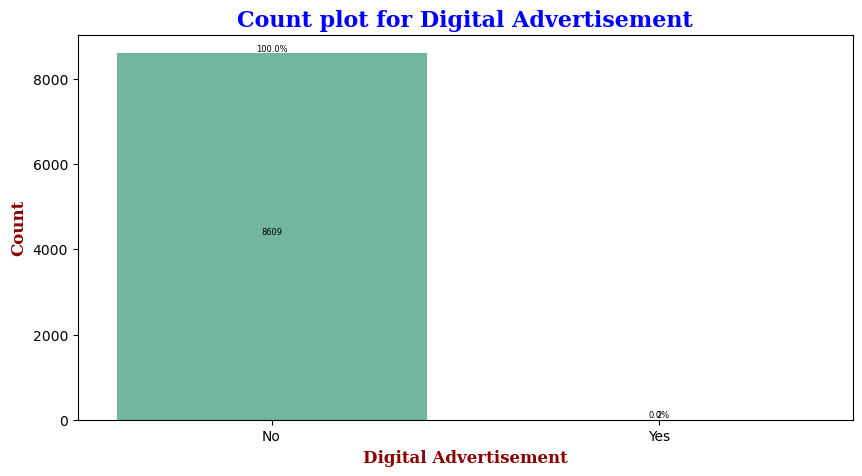

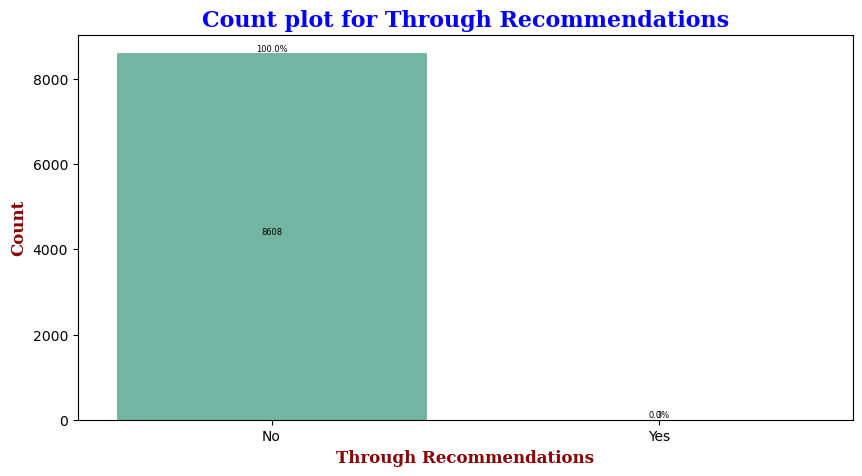

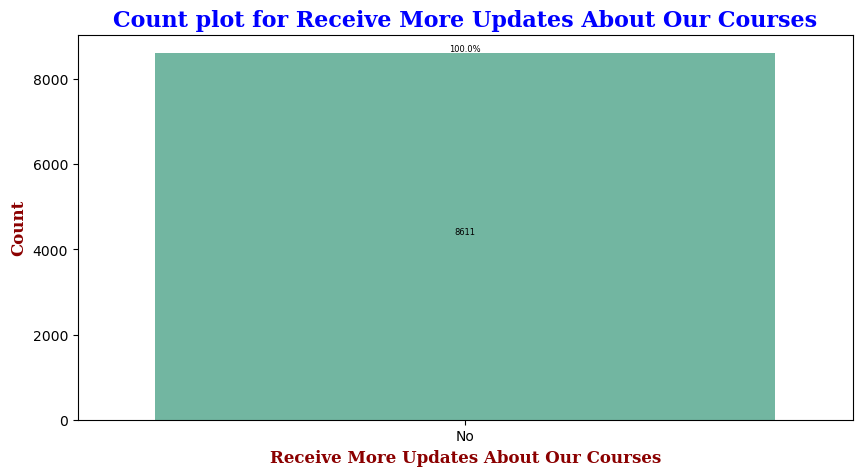

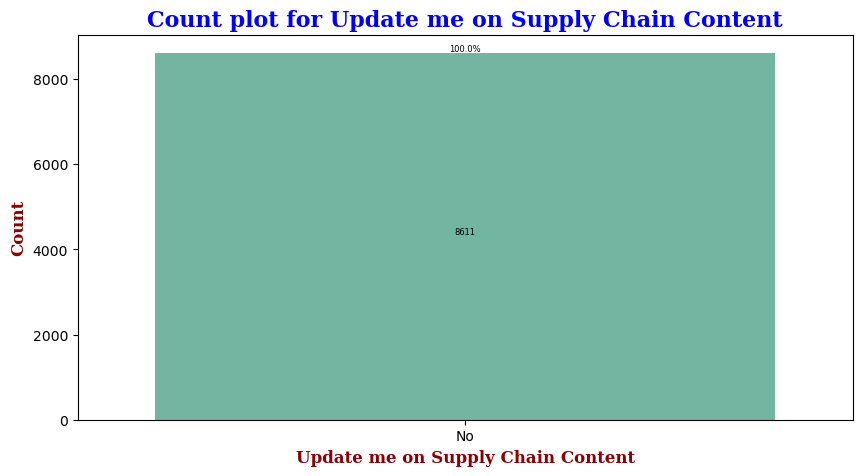

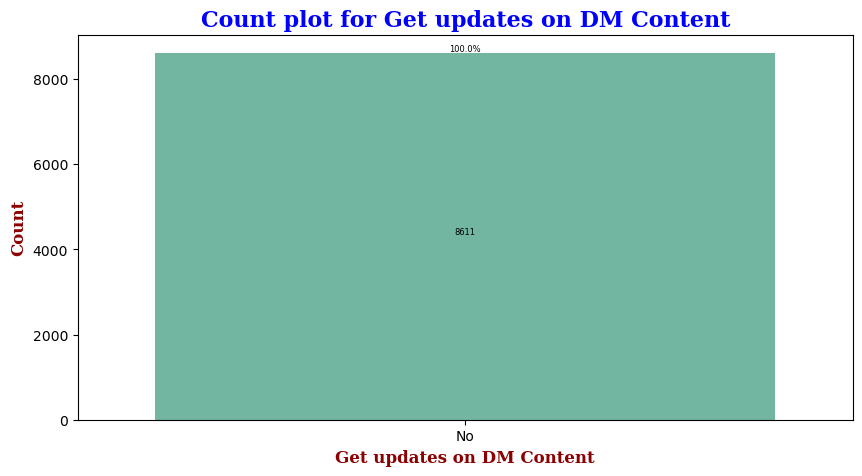

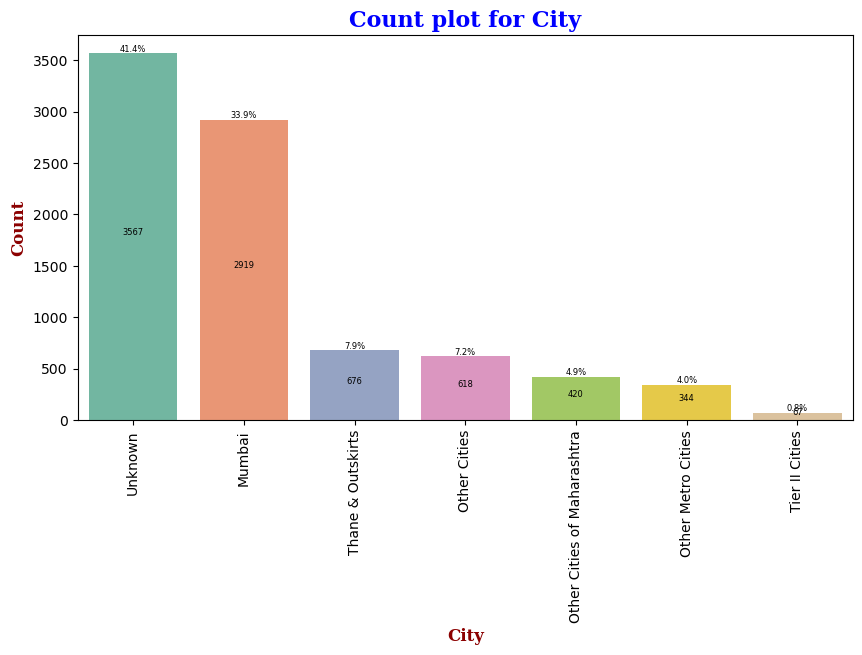

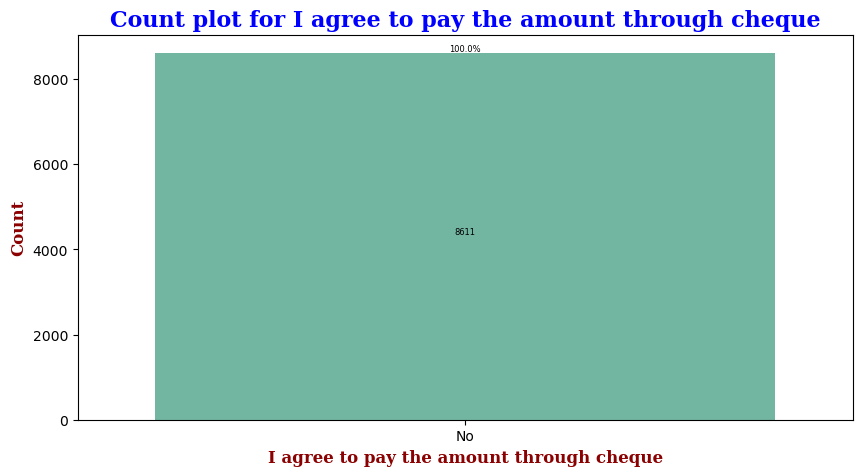

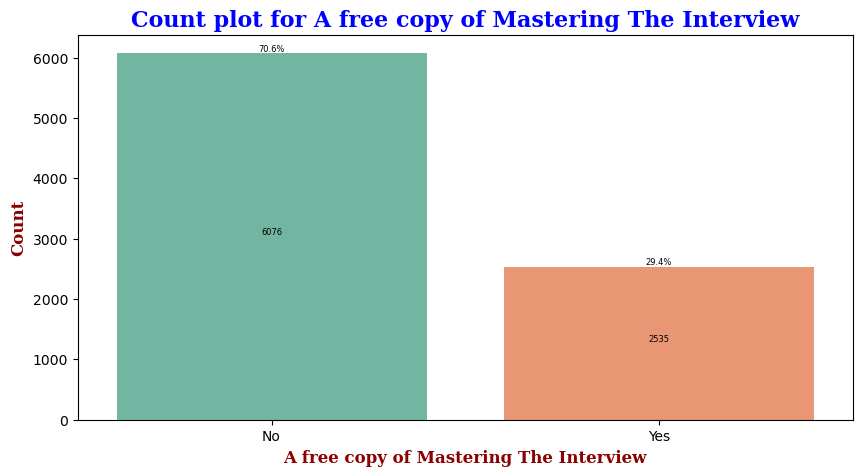

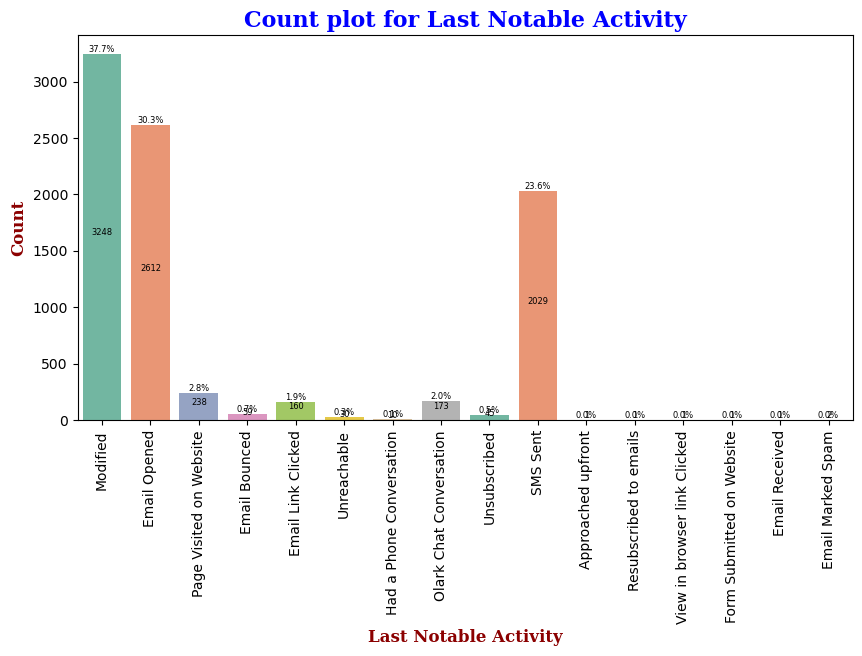

In [54]:
catg_cols = get_categorical_columns_based_on_datatype(df)

for col_name in catg_cols:
    unique_xticks = df[col_name].nunique()
        
    plt.figure(figsize=[10,5])
    
    ax = sns.countplot(x=col_name, data=df, palette='Set2')
    plt.title(f'Count plot for {col_name}',fontdict = title_dict)
    plt.xlabel(f'{col_name}', fontdict= label_dict)
    if  unique_xticks > 4:
        plt.xticks(rotation=90)
    plt.ylabel('Count', fontdict=label_dict)
    # Calculate percentages
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total) * 100
        ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom',fontsize=6)
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height/2), ha='center', va='bottom',fontsize=6)
    plt.show()

### 3.2: Univariate Numerical Column Analysis 

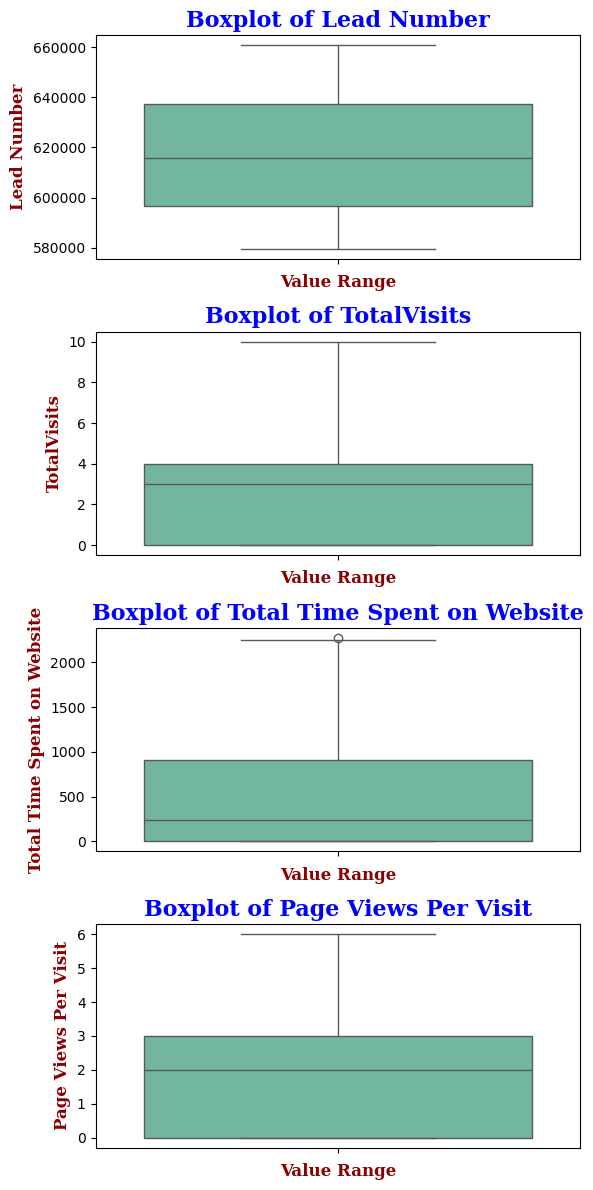

In [56]:
num_cols = get_numerical_columns_based_on_datatype(df)

num_cols_len = len(num_cols)
fig, axes = plt.subplots(num_cols_len, 1, figsize=(6, 3 * num_cols_len))

# Loop through each column and create a boxplot
for i, column in enumerate(num_cols):
    sns.boxplot( y=column, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'Boxplot of {column}',fontdict = title_dict)
    axes[i].set_xlabel('Value Range', fontdict=label_dict)
    axes[i].set_ylabel(column, fontdict=label_dict)

# Adjust layout
plt.tight_layout()
plt.show()

### Univariate Analysis Summary:
1. 50% of the leads arrived from the Landing page submission followed by API
2. 31% of the leads sourced via Google followed by Direct Traffic way
3. **38.5%** of the leads have converted to hot leads who is contributing to the revenue of X company.
4. For most of the leads, marketing company has contacted via Email and SMS which contributes 60% of Last Activity happened
5. 70% of the leads belongs to India while 25% of leads are Unknown
6. 60% of the leads are unemployed and we do not know the current occupation of 29% of leads. So we do not know 36% of the leads' specialization.
7. 70% of the leads opting for the course to have Better Career Prospects. This shows people are upgrading their skills.
8. There are columns like 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums',  'Newspaper' etc having High dominance in column values. Almost 98% of column values have same value. Hence these columns could be dropped

### 3.3: Dropping High Dominance columns
-  As you can observe from the Univariate Categorical Analysis, columns like 'Do Not Call', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums',  'Newspaper' etc having High dominance in their column values. 
-  Almost 98% of column values have same value. Hence these columns could be dropped.
- High dominance columns are those having 95% of column values are same.

In [59]:
columns_with_high_dominance = get_high_dominance_columns(df)
columns_with_high_dominance

['Do Not Call',
 'Search',
 'Magazine',
 'Newspaper Article',
 'X Education Forums',
 'Newspaper',
 'Digital Advertisement',
 'Through Recommendations',
 'Receive More Updates About Our Courses',
 'Update me on Supply Chain Content',
 'Get updates on DM Content',
 'I agree to pay the amount through cheque']

In [60]:
df = df.drop(columns_with_high_dominance, axis=1)
df.shape

(8611, 16)

In [61]:
get_summary_data(df)

Shape: (8611, 16)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


,column_name,data_type,null_percentage,unique_value_count,value_count
0,Lead Number,int64,0.0,NaN,NaN
1,Lead Origin,object,0.0,5.0,"(Landing Page Submission, API, Lead Add Form, ..."
2,Lead Source,object,0.0,22.0,"(Google, Direct Traffic, Olark Chat, Organic S..."
3,Do Not Email,object,0.0,2.0,"(No, Yes)"
4,Converted,object,0.0,2.0,"(No, Yes)"
5,TotalVisits,float64,0.0,11.0,"(0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 1.0, 7.0, 8.0, ..."
6,Total Time Spent on Website,int64,0.0,NaN,NaN
7,Page Views Per Visit,float64,0.0,26.0,"(0.0, 2.0, 3.0, 4.0, 1.0, 5.0, 1.5, 2.5, 6.0, ..."
8,Last Activity,object,0.0,18.0,"(Email Opened, SMS Sent, Olark Chat Conversati..."
9,Country,object,0.0,NaN,NaN


### 3.4: As data is cleaned and removed unwanted columns. We can rename the columns to more meaningful

In [63]:
rename_columns_dict = {
    'Lead Number': 'lead_number', 
    'Lead Origin': 'lead_origin', 
    'Lead Source': 'lead_source',
    'Do Not Email': 'email_unsubscribe', 
    'Converted': 'converted',
    'TotalVisits': 'total_visits', 
    'Total Time Spent on Website': 'time_spend_website', 
    'Page Views Per Visit': 'page_views_per_visit',
    'Last Activity': 'last_activity', 
    'Country': 'country', 
    'Specialization': 'specialization',
    'What is your current occupation': 'curr_occupation',
    'What matters most to you in choosing a course': 'course_purpose', 
    'Tags': 'tags', 
    'City': 'city',
    'A free copy of Mastering The Interview': 'subscribe_master_interview', 
    'Last Notable Activity': 'last_notable_activity'}
# rename_columns_dict

In [64]:
df = df.rename(rename_columns_dict, axis=1)
df.head()

,lead_number,lead_origin,lead_source,email_unsubscribe,converted,total_visits,time_spend_website,page_views_per_visit,last_activity,country,specialization,curr_occupation,course_purpose,city,subscribe_master_interview,last_notable_activity
0,660737,API,Olark Chat,No,No,0.0,0,0.0,Page Visited on Website,Unknown,Unknown,Unemployed,Better Career Prospects,Unknown,No,Modified
1,660728,API,Organic Search,No,No,5.0,674,2.5,Email Opened,India,Unknown,Unemployed,Better Career Prospects,Unknown,No,Email Opened
2,660727,Landing Page Submission,Direct Traffic,No,Yes,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,Mumbai,Yes,Email Opened
3,660719,Landing Page Submission,Direct Traffic,No,No,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,Mumbai,No,Modified
4,660681,Landing Page Submission,Google,No,Yes,2.0,1428,1.0,Converted to Lead,India,Unknown,Unemployed,Better Career Prospects,Mumbai,No,Modified


In [66]:
givespace()

## 4. Bivariate Analysis

### 4.1: Bivariate Analysis on Categorical columns

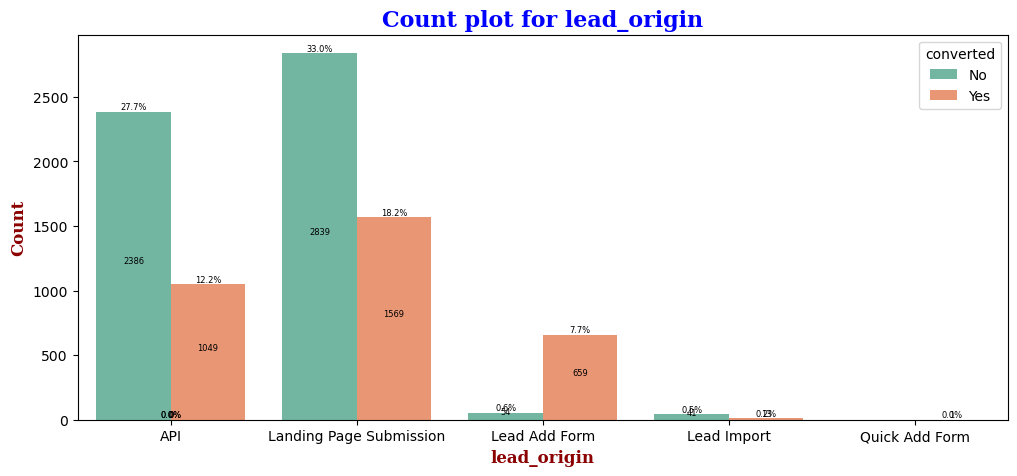

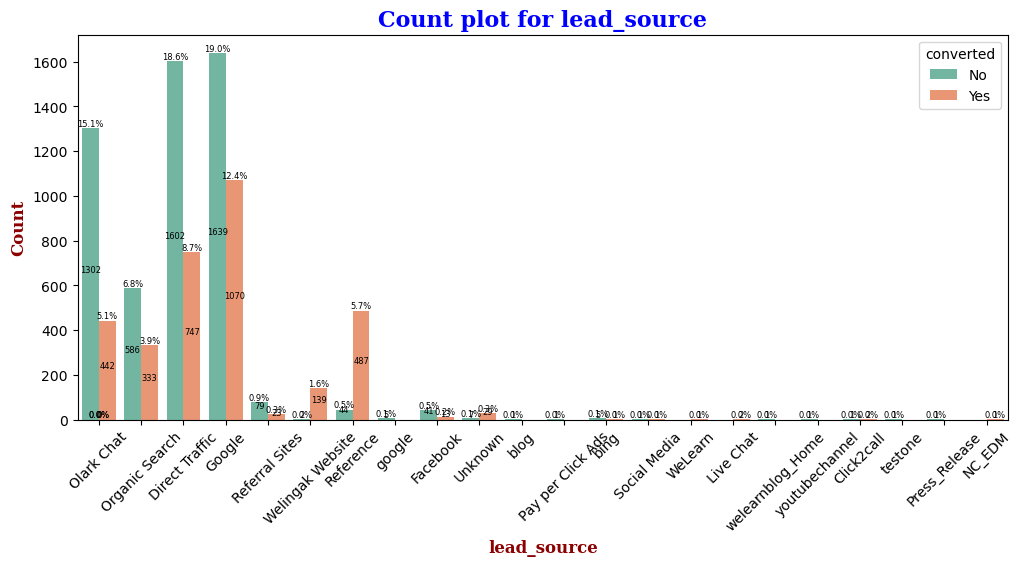

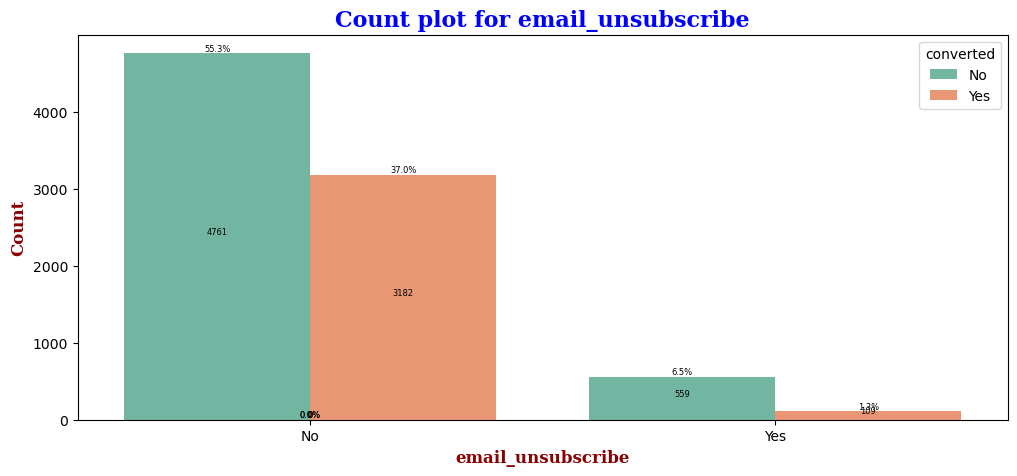

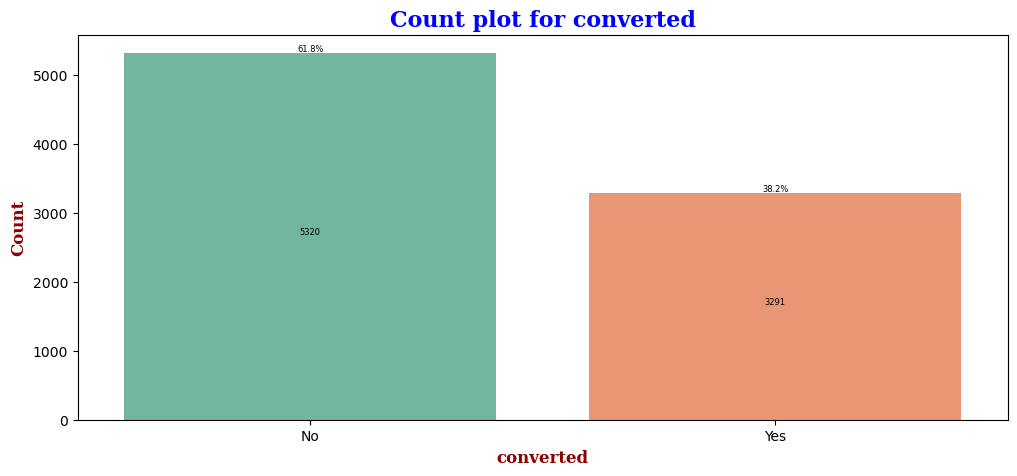

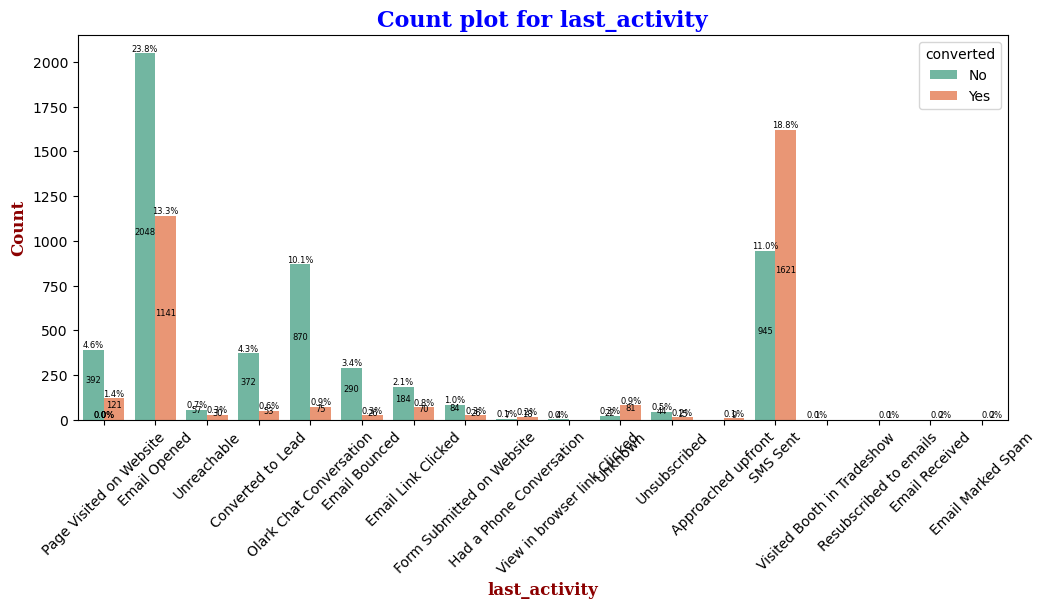

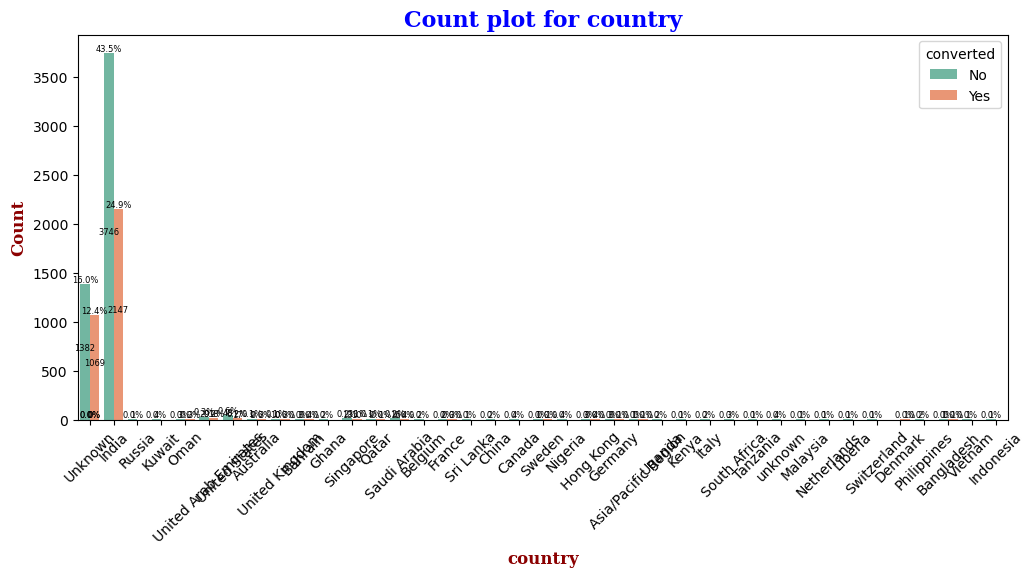

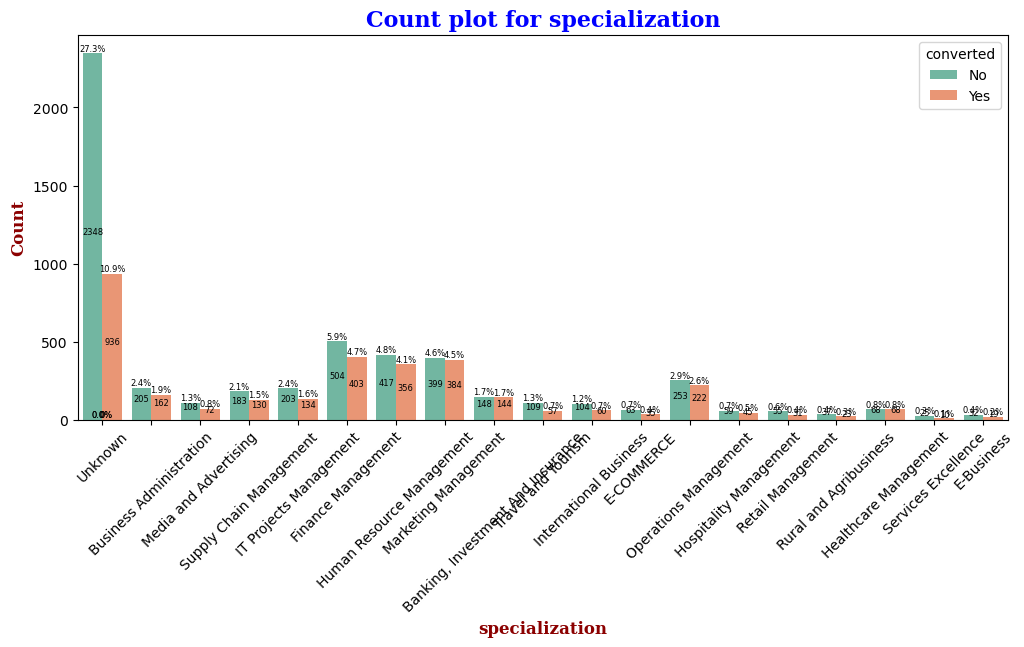

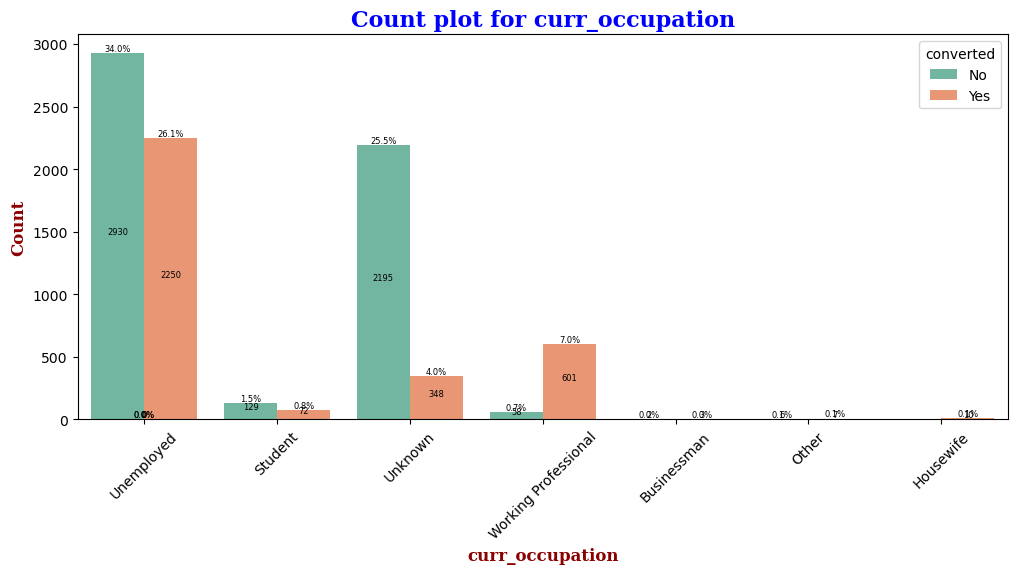

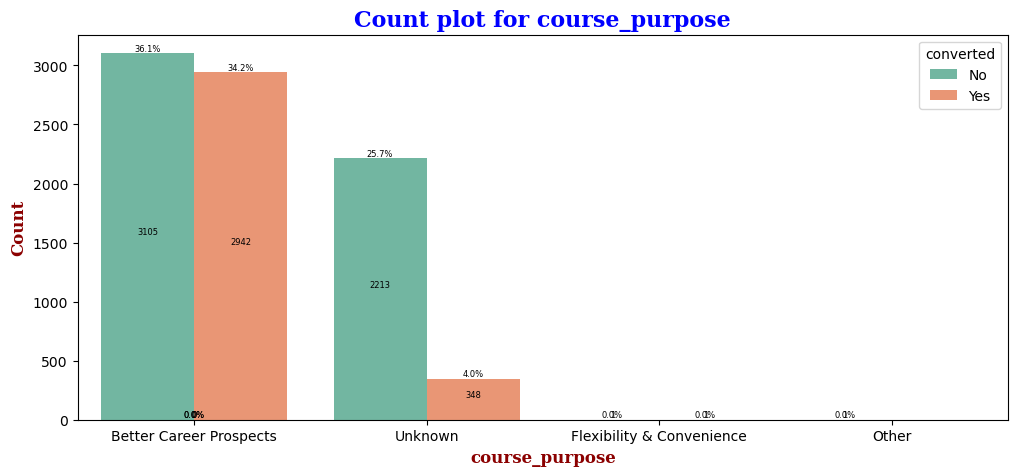

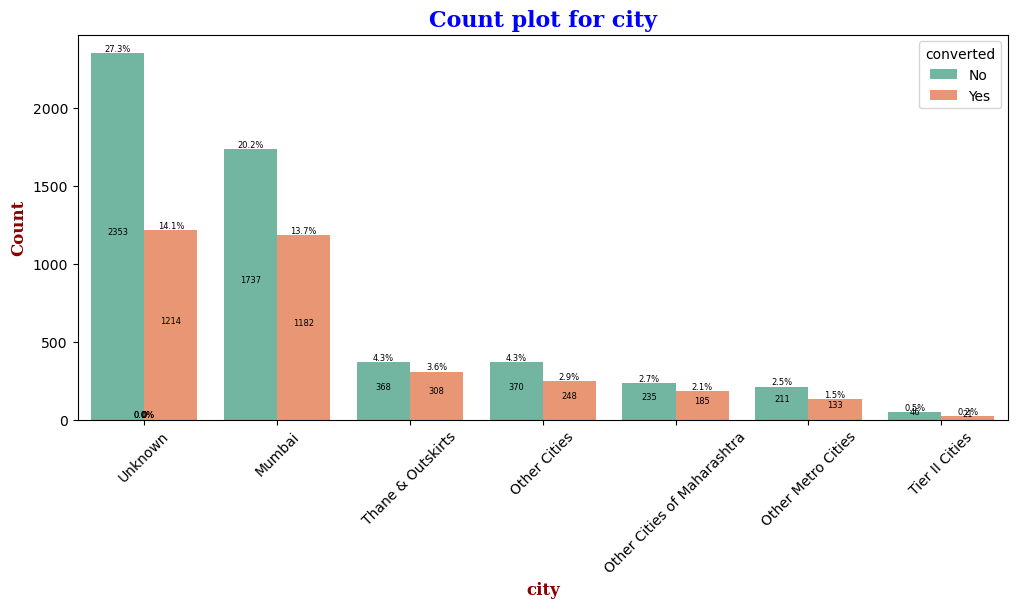

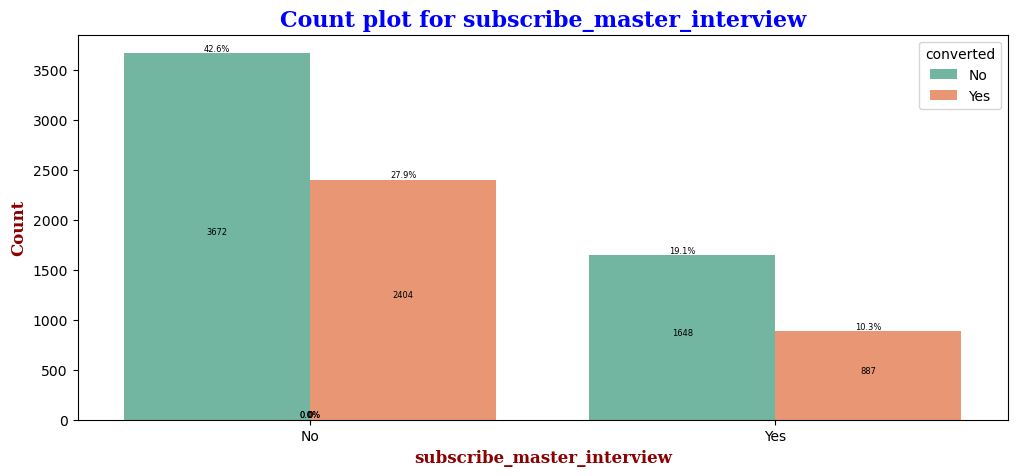

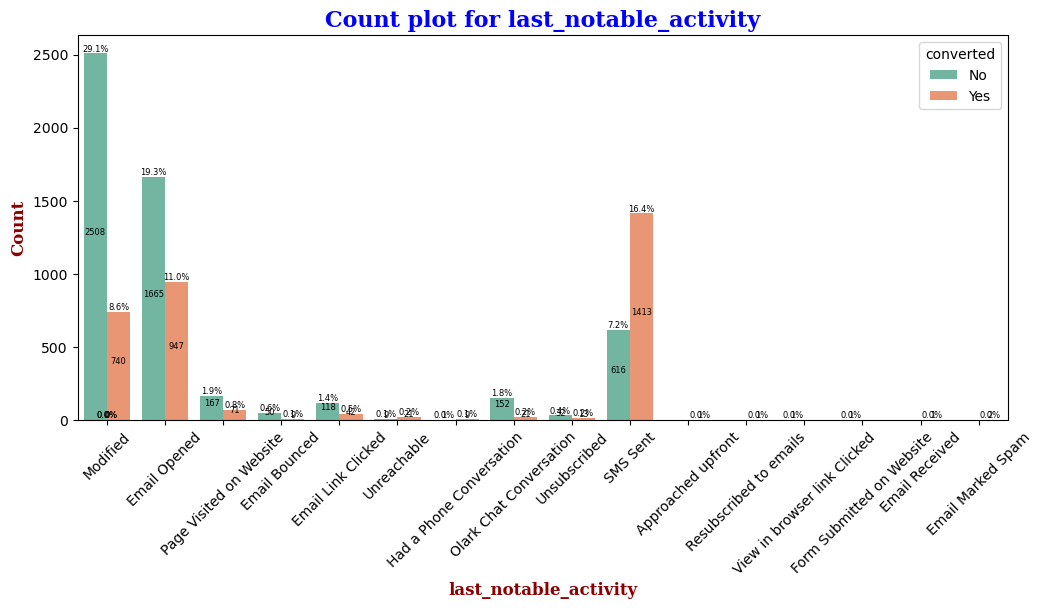

In [69]:
catg_cols = get_categorical_columns_based_on_datatype(df)

for col_name in catg_cols:
    unique_xticks = df[col_name].nunique()
        
    plt.figure(figsize=[12,5])
    
    ax = sns.countplot(x=col_name, hue='converted', data=df, palette='Set2')
    plt.title(f'Count plot for {col_name}',fontdict = title_dict)
    plt.xlabel(f'{col_name}', fontdict= label_dict)
    if  unique_xticks > 6:
        plt.xticks(rotation=45)
    plt.ylabel('Count', fontdict=label_dict)
    # Calculate percentages
    total = len(df)
    for p in ax.patches:
        height = p.get_height()
        percentage = (height / total) * 100
        ax.annotate(f'{percentage:.1f}%', (p.get_x() + p.get_width() / 2., height), ha='center', va='bottom',fontsize=6)
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height/2), ha='center', va='bottom',fontsize=6)
    plt.show()

### 4.2: Bivariate Analysis on Numerical columns

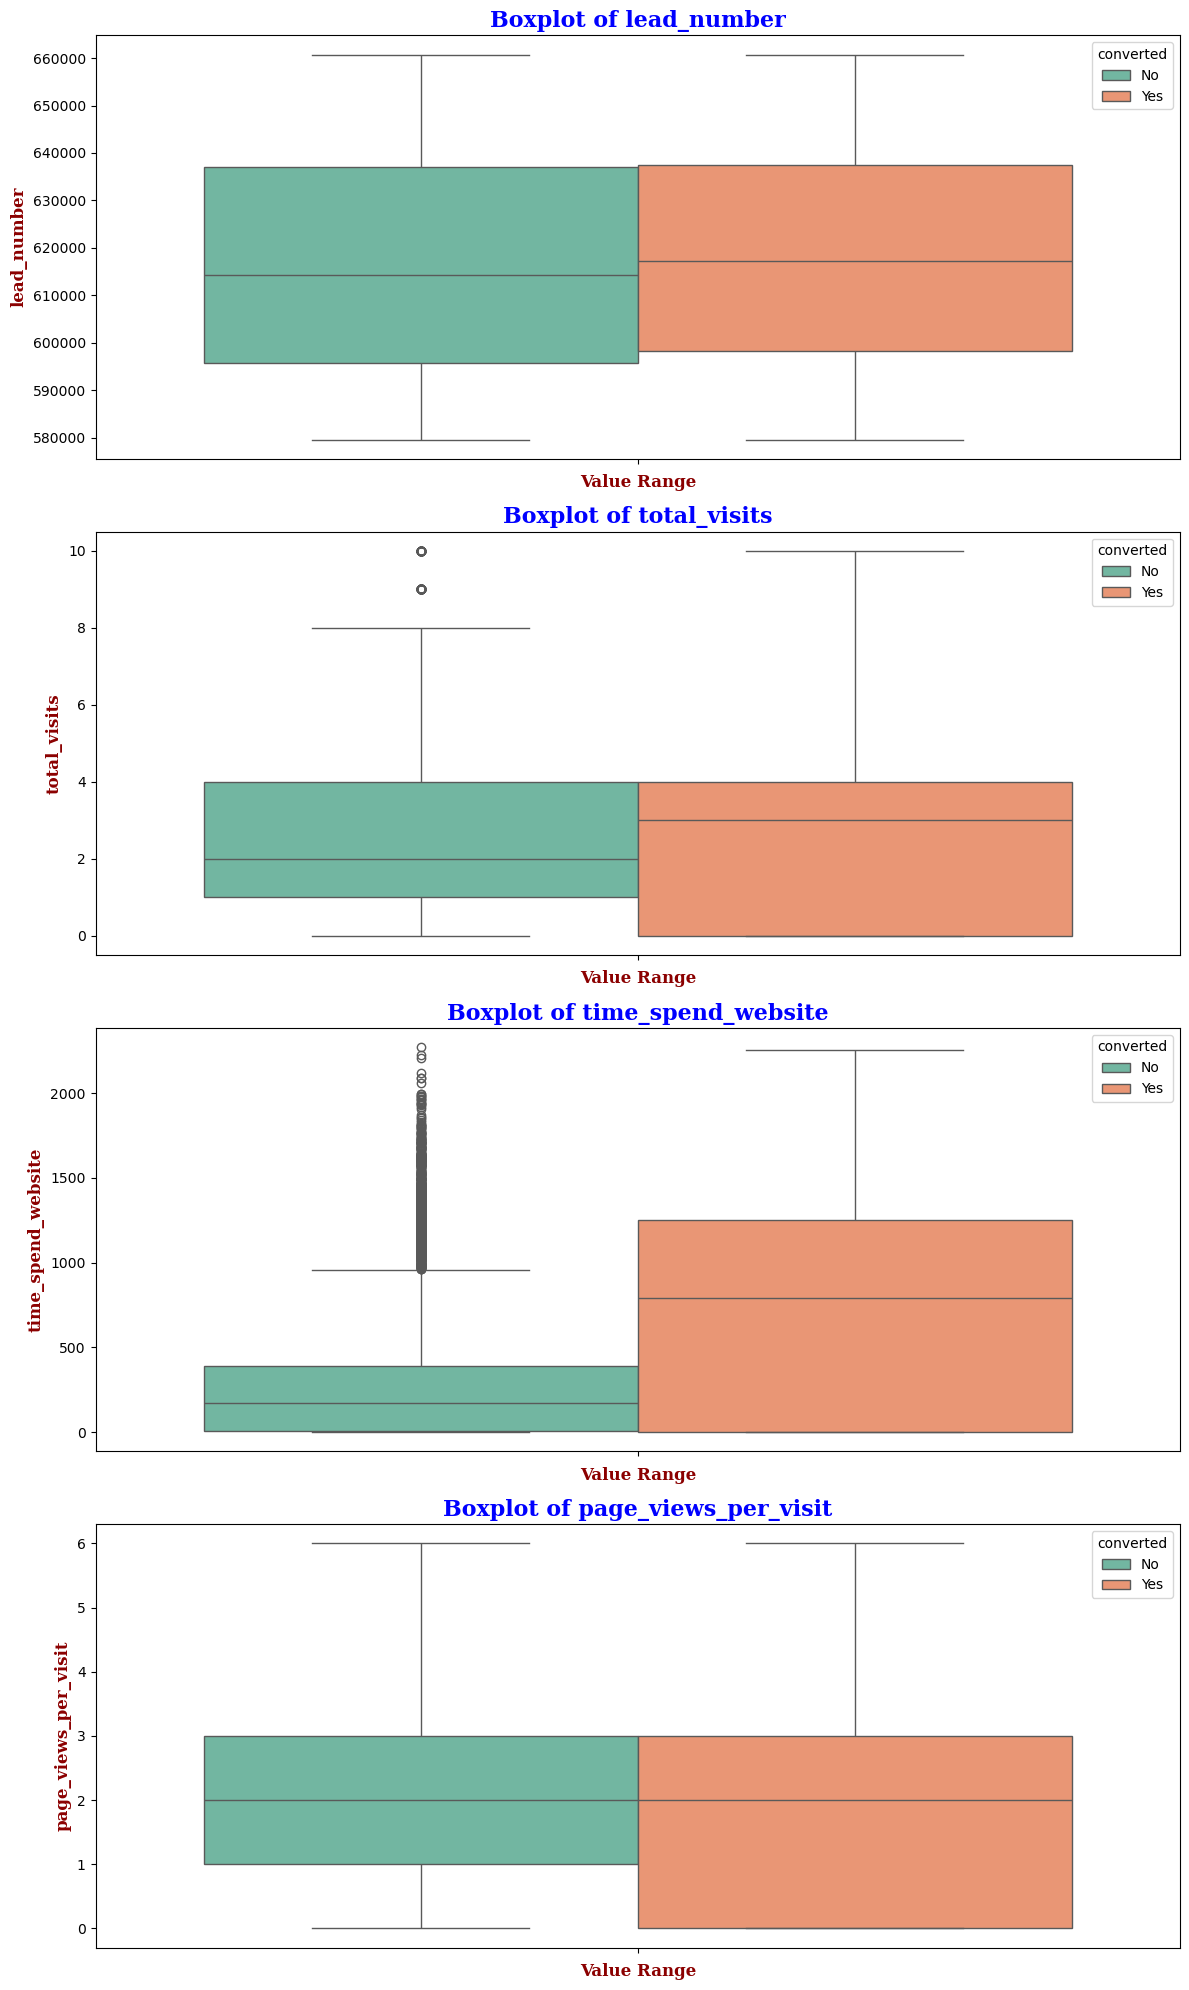

In [72]:
num_cols = get_numerical_columns_based_on_datatype(df)

num_cols_len = len(num_cols)
fig, axes = plt.subplots(num_cols_len, 1, figsize=(12, 5 * num_cols_len))

# Loop through each column and create a boxplot
for i, column in enumerate(num_cols):
    sns.boxplot( y=column, data=df, hue= 'converted', ax=axes[i], palette='Set2')
    axes[i].set_title(f'Boxplot of {column}',fontdict = title_dict)
    axes[i].set_xlabel('Value Range', fontdict=label_dict)
    axes[i].set_ylabel(column, fontdict=label_dict)

# Adjust layout
plt.tight_layout()
plt.show()

In [73]:
df.describe()

,lead_number,total_visits,time_spend_website,page_views_per_visit
count,8611.000000,8611.000000,8611.000000,8611.000000
mean,617167.853792,2.749042,474.010219,2.064067
std,23352.816679,2.313338,544.887965,1.637341
min,579533.000000,0.000000,0.000000,0.000000
25%,596480.500000,0.000000,0.000000,0.000000
50%,615658.000000,3.000000,235.000000,2.000000
75%,637208.000000,4.000000,904.000000,3.000000
max,660737.000000,10.000000,2272.000000,6.000000


## Bivariate Analysis Summary
1. The lead conversion rate is highest for Lead Originating from **Lead Add Form** folowed by **Landing Page Submission** of the online education company.
2. Most lead source are through Olark Chat, Direct Traffic and Google, but the leads arriving via **Welingak Website** and through **reference** have the highest lead conversion rate.
3. 37% of the leads have opt for the courses even they have not subscribe for the email.
4. The data contains 62:38 ratio of conversion data which is having clear balanced data.
5. Most of the leads have **Email Opened** and **SMS Sent** as their last_activity. Hence engaging the customers via contact details works.
6. Most of customers are from India, hence not much inference can be concluded.
7. Under the **Specialization** column, we could see most leads are from **Unknown** category, this population is clearly are students or unemployed people. We could also see good conversion rate among **Working Professionals**.
8. **Working Professional** has highest conversion rate as you could see in the **curr_occupation** plot. Unemployed and Students category has lesser conversion rate compared to working professional.
9. Most Working Professional opt the course for **Better Career Prospects**, hence there is a good conversion rate.
10. Customers from **Mumbai** has  40% chance of converting to lead.
11. There is **70%** of lead conversion chance for the customers when the company engage with them through SMS. This is observed in Last_notable_activity plot.
12. The mean value of **total_visits** value is higher for leads who have converted. So higher the **total_visits**, higher the lead conversion rate.
13. Lead Customers often spend more time in website and hence there chance of conversion is more. Hence the mean value of **time_spend_website** is more for leads who opt for course.


In [76]:
givespace()

## 5. Data Preparation:

#### As it is evident from the univariate analysis, there are some categorical columns having multiple values, this would create lot of features when we apply dummy_variaables to it. Hence we need identify those columns and replace column values with 'Others' as value.


In [79]:

for col_name in catg_cols:
    print(df[col_name].value_counts(normalize=True))
    print('========================================')
    print()


lead_origin
Landing Page Submission    0.511903
API                        0.398908
Lead Add Form              0.082801
Lead Import                0.006271
Quick Add Form             0.000116
Name: proportion, dtype: float64

lead_source
Google               0.314598
Direct Traffic       0.272791
Olark Chat           0.202532
Organic Search       0.106724
Reference            0.061665
Welingak Website     0.016374
Referral Sites       0.011845
Facebook             0.006271
Unknown              0.004181
bing                 0.000697
google               0.000581
Click2call           0.000348
Social Media         0.000232
Live Chat            0.000232
youtubechannel       0.000116
Press_Release        0.000116
testone              0.000116
Pay per Click Ads    0.000116
welearnblog_Home     0.000116
WeLearn              0.000116
blog                 0.000116
NC_EDM               0.000116
Name: proportion, dtype: float64

email_unsubscribe
No     0.922425
Yes    0.077575
Name: proportion, 

In [80]:
multiple_categorical_column_list = ['lead_origin', 'lead_source', 'last_activity', 
                                     'country', 'curr_occupation', 'city', 'last_notable_activity']

for col_name in multiple_categorical_column_list:
    df = merge_low_freq_multiple_catg_values(df, col_name)

get_summary_data(df)

Shape: (8611, 16)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


,column_name,data_type,null_percentage,unique_value_count,value_count
0,lead_number,int64,0.0,NaN,NaN
1,lead_origin,object,0.0,4.0,"(Landing Page Submission, API, Lead Add Form, ..."
2,lead_source,object,0.0,8.0,"(Google, Direct Traffic, Olark Chat, Organic S..."
3,email_unsubscribe,object,0.0,2.0,"(No, Yes)"
4,converted,object,0.0,2.0,"(No, Yes)"
5,total_visits,float64,0.0,11.0,"(0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 1.0, 7.0, 8.0, ..."
6,time_spend_website,int64,0.0,NaN,NaN
7,page_views_per_visit,float64,0.0,26.0,"(0.0, 2.0, 3.0, 4.0, 1.0, 5.0, 1.5, 2.5, 6.0, ..."
8,last_activity,object,0.0,11.0,"(Email Opened, SMS Sent, Olark Chat Conversati..."
9,country,object,0.0,3.0,"(India, Unknown, Others)"


## 5.1 Next step is to convert categorical values to Numeric or Binary values

### As seen above there are columns having Yes/No category, so we need to convert it to Binary format

In [83]:
yes_no_catg_columns = ['email_unsubscribe', 'converted', 'subscribe_master_interview']

def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

df[yes_no_catg_columns] = df[yes_no_catg_columns].apply(binary_map)

df.head()

,lead_number,lead_origin,lead_source,email_unsubscribe,converted,total_visits,time_spend_website,page_views_per_visit,last_activity,country,specialization,curr_occupation,course_purpose,city,subscribe_master_interview,last_notable_activity
0,660737,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Unknown,Unknown,Unemployed,Better Career Prospects,Unknown,0,Modified
1,660728,API,Organic Search,0,0,5.0,674,2.5,Email Opened,India,Unknown,Unemployed,Better Career Prospects,Unknown,0,Email Opened
2,660727,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,Mumbai,1,Email Opened
3,660719,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,Mumbai,0,Modified
4,660681,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,India,Unknown,Unemployed,Better Career Prospects,Mumbai,0,Modified


In [84]:
df.columns

Index(['lead_number', 'lead_origin', 'lead_source', 'email_unsubscribe',
       'converted', 'total_visits', 'time_spend_website',
       'page_views_per_visit', 'last_activity', 'country', 'specialization',
       'curr_occupation', 'course_purpose', 'city',
       'subscribe_master_interview', 'last_notable_activity'],
      dtype='object')

### 5.2: Generating Dummy variables for categorical columns

In [86]:
dummy_df = pd.get_dummies(df[['lead_origin', 'lead_source', 'last_activity', 'country', 'specialization', 'curr_occupation',
'course_purpose', 'city', 'last_notable_activity']], dtype=int, drop_first= True)

dummy_df.head()

,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Others,lead_source_Google,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Others,lead_source_Reference,lead_source_Referral Sites,lead_source_Welingak Website,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Opened,last_activity_Form Submitted on Website,last_activity_Olark Chat Conversation,last_activity_Others,last_activity_Page Visited on Website,last_activity_SMS Sent,last_activity_Unknown,last_activity_Unreachable,country_Others,country_Unknown,specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism,specialization_Unknown,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Unknown,curr_occupation_Working Professional,course_purpose_Flexibility & Convenience,course_purpose_Other,course_purpose_Unknown,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,city_Unknown,last_notable_activity_Email Opened,last_notable_activity_Modified,last_notable_activity_Olark Chat Conversation,last_notable_activity_Others,last_notable_activity_Page Visited on Website,last_notable_activity_SMS Sent
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [87]:
lead_data_df = pd.concat([df, dummy_df], axis=1)
lead_data_df.head()

,lead_number,lead_origin,lead_source,email_unsubscribe,converted,total_visits,time_spend_website,page_views_per_visit,last_activity,country,specialization,curr_occupation,course_purpose,city,subscribe_master_interview,last_notable_activity,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Others,lead_source_Google,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Others,lead_source_Reference,lead_source_Referral Sites,lead_source_Welingak Website,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Opened,last_activity_Form Submitted on Website,last_activity_Olark Chat Conversation,last_activity_Others,last_activity_Page Visited on Website,last_activity_SMS Sent,last_activity_Unknown,last_activity_Unreachable,country_Others,country_Unknown,specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism,specialization_Unknown,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Unknown,curr_occupation_Working Professional,course_purpose_Flexibility & Convenience,course_purpose_Other,course_purpose_Unknown,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,city_Unknown,last_notable_activity_Email Opened,last_notable_activity_Modified,last_notable_activity_Olark Chat Conversation,last_notable_activity_Others,last_notable_activity_Page Visited on Website,last_notable_activity_SMS Sent
0,660737,API,Olark Chat,0,0,0.0,0,0.0,Page Visited on Website,Unknown,Unknown,Unemployed,Better Career Prospects,Unknown,0,Modified,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,660728,API,Organic Search,0,0,5.0,674,2.5,Email Opened,India,Unknown,Unemployed,Better Career Prospects,Unknown,0,Email Opened,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,660727,Landing Page Submission,Direct Traffic,0,1,2.0,1532,2.0,Email Opened,India,Business Administration,Student,Better Career Prospects,Mumbai,1,Email Opened,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,660719,Landing Page Submission,Direct Traffic,0,0,1.0,305,1.0,Unreachable,India,Media and Advertising,Unemployed,Better Career Prospects,Mumbai,0,Modified,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,660681,Landing Page Submission,Google,0,1,2.0,1428,1.0,Converted to Lead,India,Unknown,Unemployed,Better Career Prospects,Mumbai,0,Modified,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [88]:
lead_data_df.shape

(8611, 75)

#### Drop the original columns for which dummy variables are created

In [90]:
lead_data_df = lead_data_df.drop(['lead_origin', 'lead_source', 'last_activity', 'country', 'specialization', 'curr_occupation',
'course_purpose', 'city', 'last_notable_activity'], axis=1)

lead_data_df.shape

(8611, 66)

In [91]:
lead_data_df.head()

,lead_number,email_unsubscribe,converted,total_visits,time_spend_website,page_views_per_visit,subscribe_master_interview,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Others,lead_source_Google,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Others,lead_source_Reference,lead_source_Referral Sites,lead_source_Welingak Website,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Opened,last_activity_Form Submitted on Website,last_activity_Olark Chat Conversation,last_activity_Others,last_activity_Page Visited on Website,last_activity_SMS Sent,last_activity_Unknown,last_activity_Unreachable,country_Others,country_Unknown,specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism,specialization_Unknown,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Unknown,curr_occupation_Working Professional,course_purpose_Flexibility & Convenience,course_purpose_Other,course_purpose_Unknown,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,city_Unknown,last_notable_activity_Email Opened,last_notable_activity_Modified,last_notable_activity_Olark Chat Conversation,last_notable_activity_Others,last_notable_activity_Page Visited on Website,last_notable_activity_SMS Sent
0,660737,0,0,0.0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,660728,0,0,5.0,674,2.5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
2,660727,0,1,2.0,1532,2.0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,660719,0,0,1.0,305,1.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,660681,0,1,2.0,1428,1.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [92]:
get_summary_data(lead_data_df)

Shape: (8611, 66)

= = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = = 


,column_name,data_type,null_percentage,unique_value_count,value_count
0,lead_number,int64,0.0,NaN,NaN
1,email_unsubscribe,int64,0.0,2.0,"(0, 1)"
2,converted,int64,0.0,2.0,"(0, 1)"
3,total_visits,float64,0.0,11.0,"(0.0, 2.0, 3.0, 4.0, 5.0, 6.0, 1.0, 7.0, 8.0, ..."
4,time_spend_website,int64,0.0,NaN,NaN
5,page_views_per_visit,float64,0.0,26.0,"(0.0, 2.0, 3.0, 4.0, 1.0, 5.0, 1.5, 2.5, 6.0, ..."
6,subscribe_master_interview,int64,0.0,2.0,"(0, 1)"
7,lead_origin_Landing Page Submission,int64,0.0,2.0,"(1, 0)"
8,lead_origin_Lead Add Form,int64,0.0,2.0,"(0, 1)"
9,lead_origin_Others,int64,0.0,2.0,"(0, 1)"


### 5.3: Split data into Training and Testing dataset

In [94]:
from sklearn.model_selection import train_test_split


In [95]:
y = lead_data_df['converted']
X = lead_data_df.drop(['lead_number','converted'], axis=1)

X.shape, y.shape

((8611, 64), (8611,))

In [96]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

X_train.shape, X_test.shape

((6027, 64), (2584, 64))

In [97]:
lead_data_df.shape

(8611, 66)

### 5.4 Feature scaling

In [99]:
from sklearn.preprocessing import StandardScaler

In [100]:
scaler = StandardScaler()

X_train[['total_visits', 'time_spend_website', 'page_views_per_visit']] = scaler.fit_transform(X_train[['total_visits', 'time_spend_website', 'page_views_per_visit']])

X_train.head()

,email_unsubscribe,total_visits,time_spend_website,page_views_per_visit,subscribe_master_interview,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Others,lead_source_Google,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Others,lead_source_Reference,lead_source_Referral Sites,lead_source_Welingak Website,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Opened,last_activity_Form Submitted on Website,last_activity_Olark Chat Conversation,last_activity_Others,last_activity_Page Visited on Website,last_activity_SMS Sent,last_activity_Unknown,last_activity_Unreachable,country_Others,country_Unknown,specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism,specialization_Unknown,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Unknown,curr_occupation_Working Professional,course_purpose_Flexibility & Convenience,course_purpose_Other,course_purpose_Unknown,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,city_Unknown,last_notable_activity_Email Opened,last_notable_activity_Modified,last_notable_activity_Olark Chat Conversation,last_notable_activity_Others,last_notable_activity_Page Visited on Website,last_notable_activity_SMS Sent
532,0,0.106035,-0.442813,0.569927,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
7273,0,1.834432,2.375255,-0.407388,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4998,0,-1.190262,-0.870128,-1.262538,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
6668,0,0.106035,-0.247575,0.569927,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2917,0,-1.190262,-0.870128,-1.262538,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [101]:
X_train.describe()

,email_unsubscribe,total_visits,time_spend_website,page_views_per_visit,subscribe_master_interview,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_origin_Others,lead_source_Google,lead_source_Olark Chat,lead_source_Organic Search,lead_source_Others,lead_source_Reference,lead_source_Referral Sites,lead_source_Welingak Website,last_activity_Email Bounced,last_activity_Email Link Clicked,last_activity_Email Opened,last_activity_Form Submitted on Website,last_activity_Olark Chat Conversation,last_activity_Others,last_activity_Page Visited on Website,last_activity_SMS Sent,last_activity_Unknown,last_activity_Unreachable,country_Others,country_Unknown,specialization_Business Administration,specialization_E-Business,specialization_E-COMMERCE,specialization_Finance Management,specialization_Healthcare Management,specialization_Hospitality Management,specialization_Human Resource Management,specialization_IT Projects Management,specialization_International Business,specialization_Marketing Management,specialization_Media and Advertising,specialization_Operations Management,specialization_Retail Management,specialization_Rural and Agribusiness,specialization_Services Excellence,specialization_Supply Chain Management,specialization_Travel and Tourism,specialization_Unknown,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Unknown,curr_occupation_Working Professional,course_purpose_Flexibility & Convenience,course_purpose_Other,course_purpose_Unknown,city_Other Cities,city_Other Cities of Maharashtra,city_Other Metro Cities,city_Thane & Outskirts,city_Tier II Cities,city_Unknown,last_notable_activity_Email Opened,last_notable_activity_Modified,last_notable_activity_Olark Chat Conversation,last_notable_activity_Others,last_notable_activity_Page Visited on Website,last_notable_activity_SMS Sent
count,6027.000000,6.027000e+03,6.027000e+03,6.027000e+03,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000,6027.000000
mean,0.081467,-6.719916e-17,-1.532613e-17,-4.244158e-17,0.294674,0.513522,0.080969,0.006471,0.312261,0.200265,0.110503,0.013771,0.059897,0.013108,0.016094,0.039157,0.030529,0.364858,0.013440,0.109341,0.011283,0.058404,0.298490,0.011614,0.011117,0.031193,0.280737,0.041646,0.005641,0.012278,0.104530,0.014269,0.012942,0.089929,0.041646,0.019413,0.088104,0.020574,0.055915,0.009623,0.007300,0.003816,0.035175,0.019744,0.382943,0.022731,0.601294,0.299320,0.073503,0.000332,0.000166,0.301809,0.072341,0.045462,0.040816,0.081135,0.008794,0.410818,0.296997,0.384271,0.020574,0.017422,0.025552,0.236436
std,0.273573,1.000083e+00,1.000083e+00,1.000083e+00,0.455934,0.499859,0.272810,0.080188,0.463454,0.400232,0.313541,0.116550,0.237316,0.113745,0.125849,0.193985,0.172053,0.481430,0.115157,0.312093,0.105627,0.234525,0.457634,0.107151,0.104857,0.173853,0.449396,0.199795,0.074903,0.110133,0.305972,0.118608,0.113033,0.286103,0.199795,0.137982,0.283469,0.141965,0.229777,0.097634,0.085137,0.061662,0.184237,0.139132,0.486145,0.149057,0.489673,0.457998,0.260981,0.018215,0.012881,0.459081,0.259073,0.208333,0.197881,0.273065,0.093370,0.492023,0.456973,0.486463,0.141965,0.130847,0.157807,0.424928
min,0.000000,-1.190262e+00,-8.701282e-01,-1.262538e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

### 5.5 Looking at correlations

In [103]:
# Importing matplotlib and seaborn
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

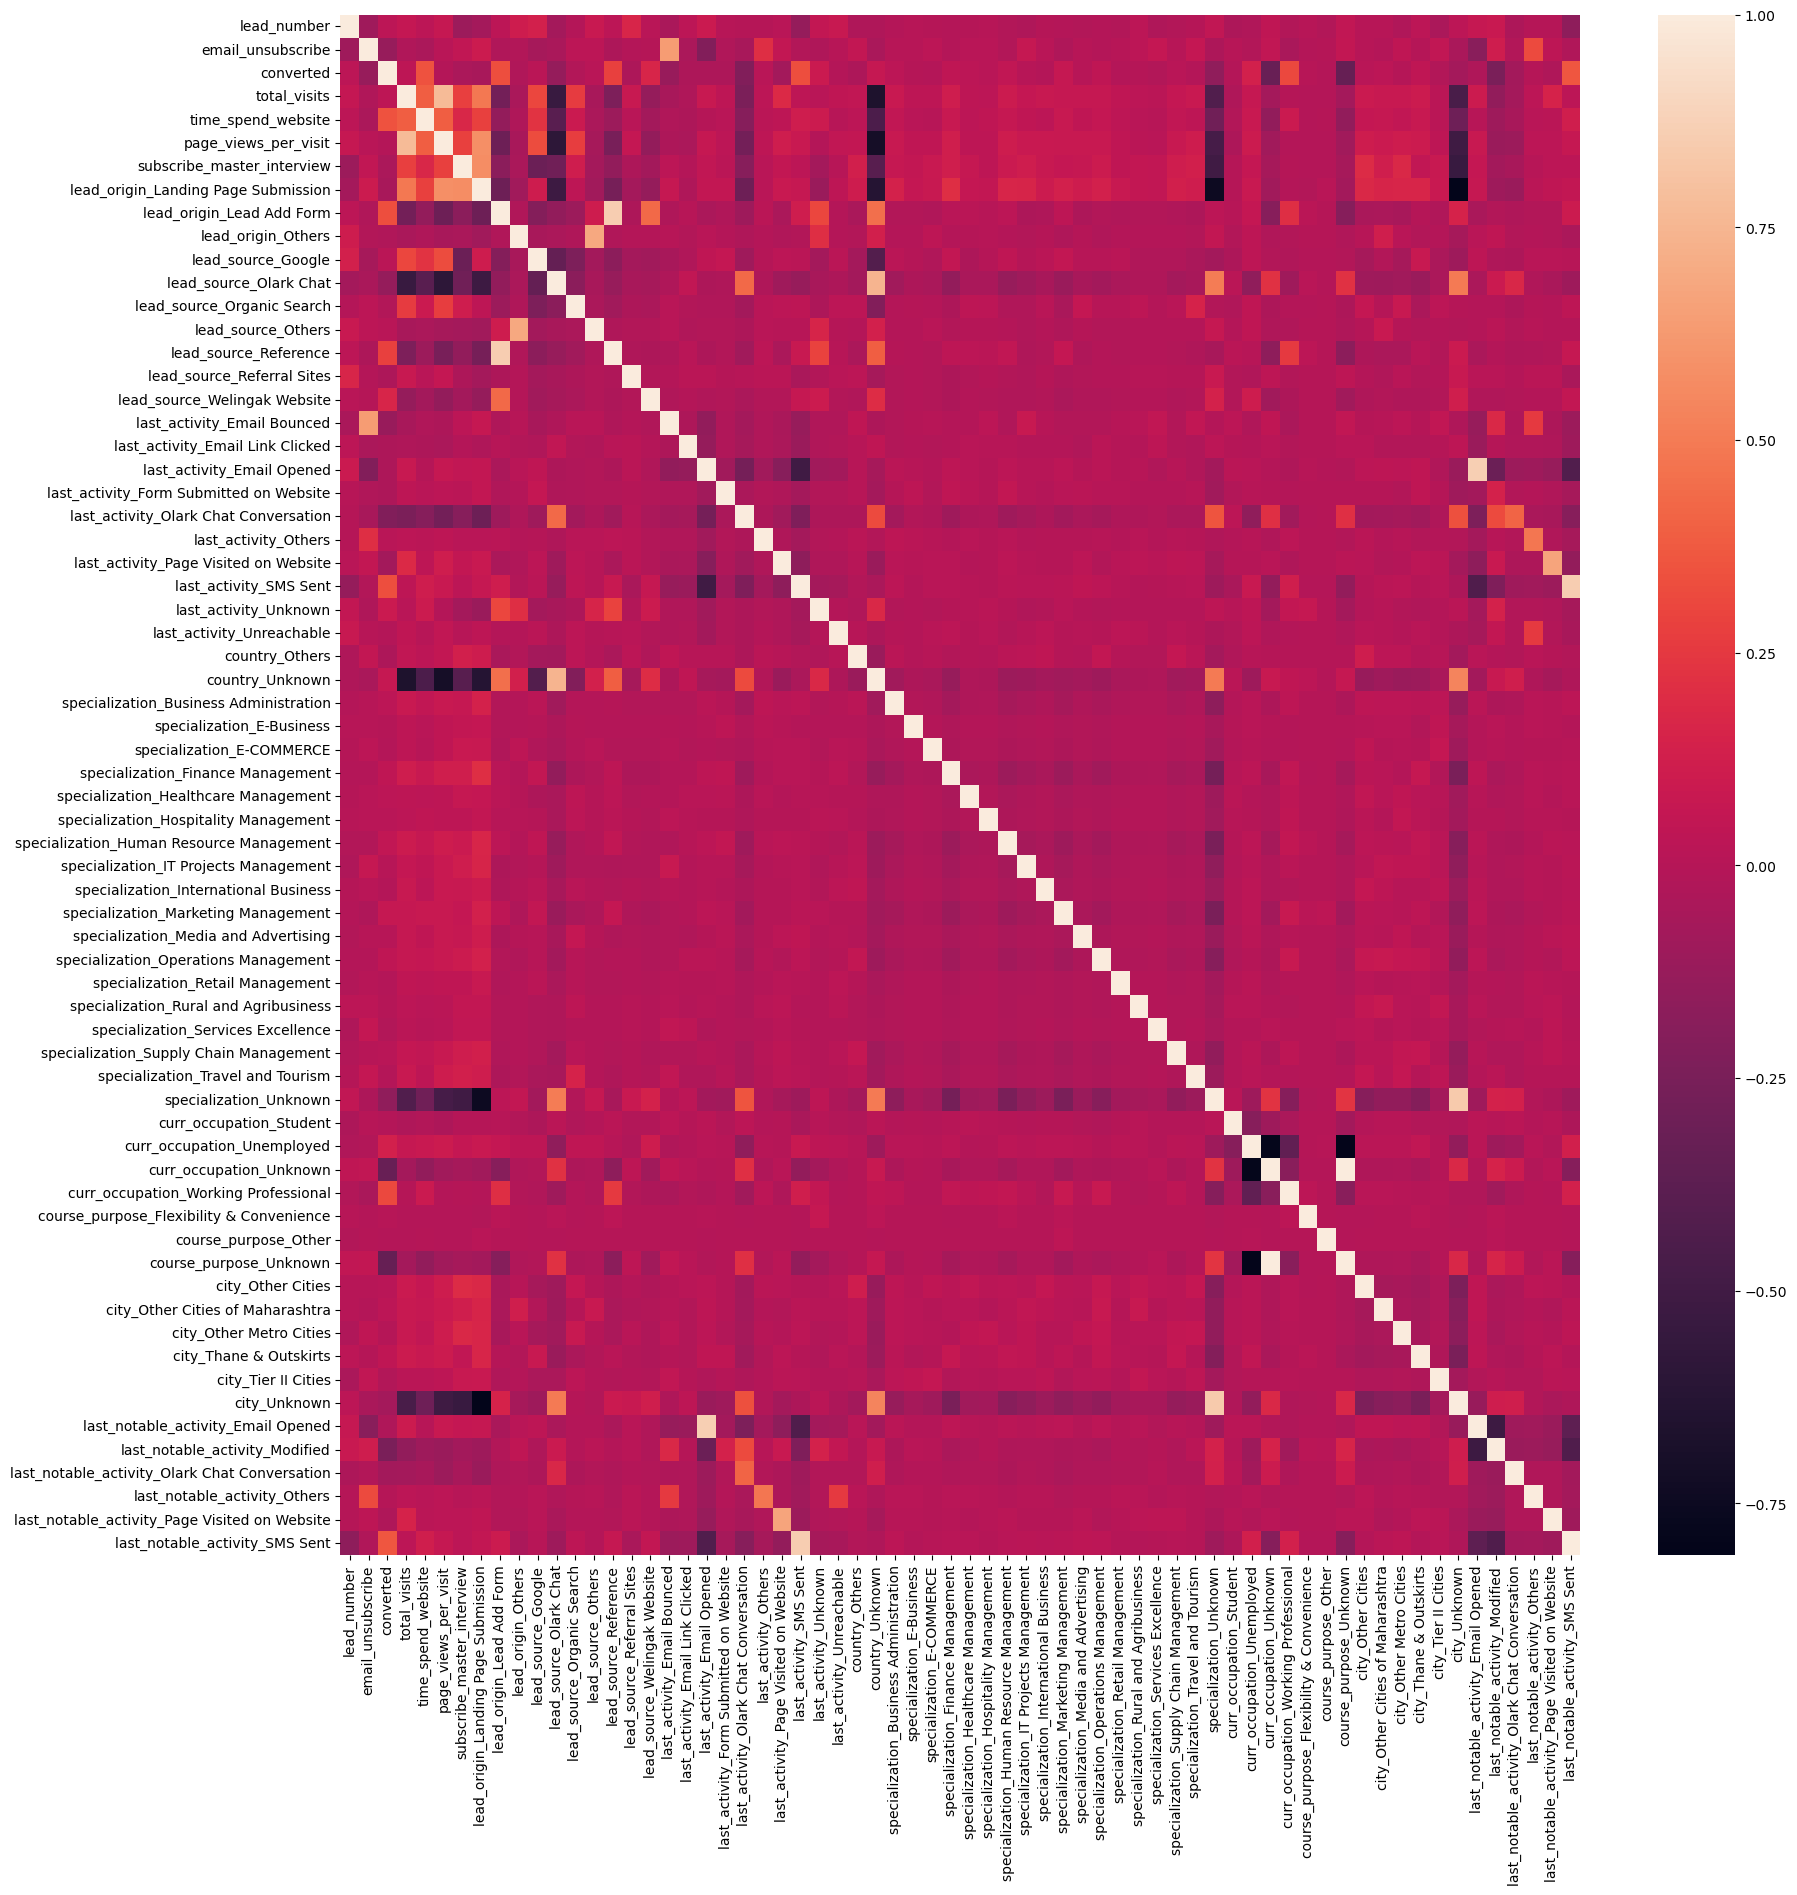

In [104]:
# Let's see the correlation matrix 
plt.figure(figsize = (20,20))        # Size of the figure
sns.heatmap(lead_data_df.corr(),annot = False)
plt.show()

### Heatmap Correlation Summary
<br> From the above heatmap, we could infer that 
- There is a correlation between **converted** column and **time_spend_website** column. So people spend more time in website researching on the course and reading the curriculum. Hence there is a high chance of convertion to potential customer.
- Leads originating from **Lead_add_form** has good conversion rate.
- 

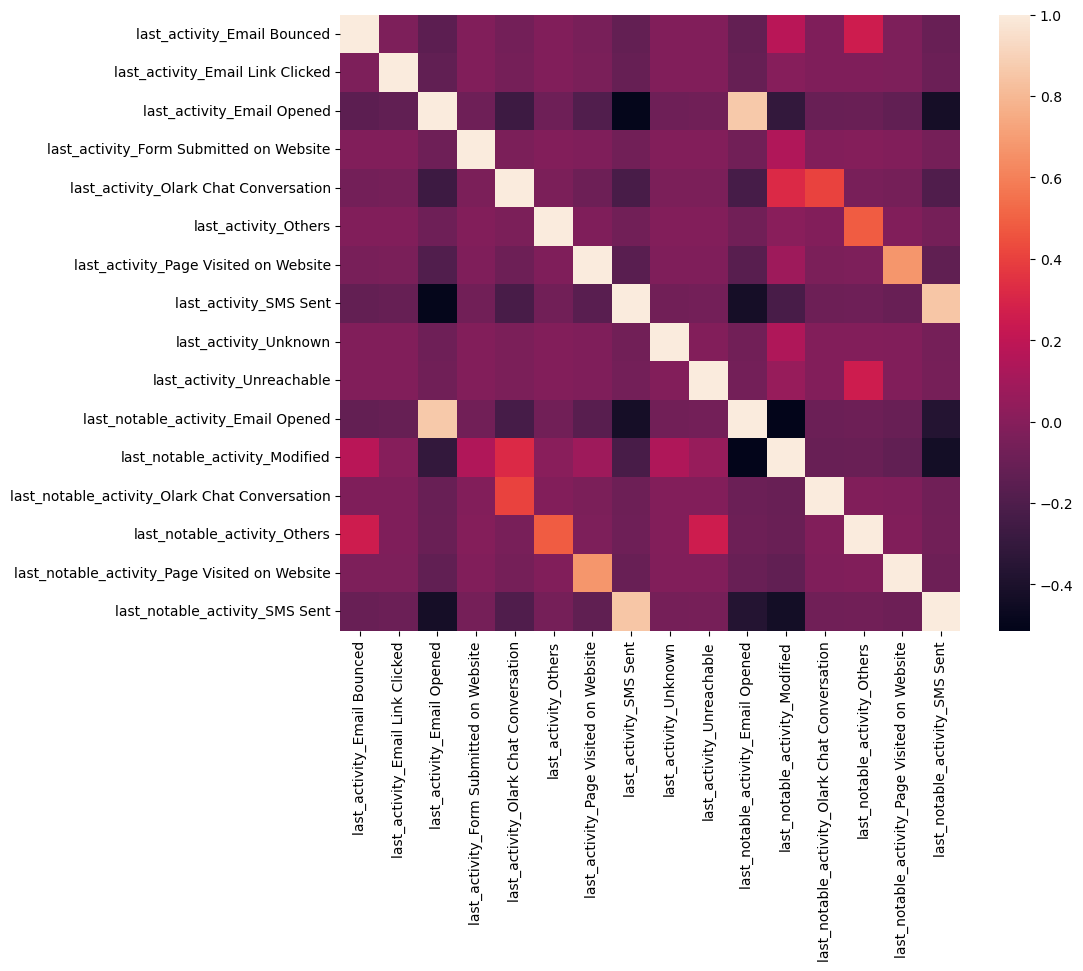

In [106]:
# Let's see the correlation matrix 
plt.figure(figsize = (10,8))        # Size of the figure
sns.heatmap(lead_data_df[['last_activity_Email Bounced', 'last_activity_Email Link Clicked',
       'last_activity_Email Opened', 'last_activity_Form Submitted on Website',
       'last_activity_Olark Chat Conversation', 'last_activity_Others',
       'last_activity_Page Visited on Website', 'last_activity_SMS Sent',
       'last_activity_Unknown', 'last_activity_Unreachable','last_notable_activity_Email Opened', 'last_notable_activity_Modified',
       'last_notable_activity_Olark Chat Conversation',
       'last_notable_activity_Others',
       'last_notable_activity_Page Visited on Website',
       'last_notable_activity_SMS Sent']].corr(),annot = False)
plt.show()

### As we can see there is correlation between the last_activity types and last_notable_activity types columns.

#### Ex: last_activity columns' email opened, olark chat conversation, page visitied on website and SMS sent.
### Hence we could drop one of them. We decided to drop last_activity. 

In [108]:
last_activity_and_last_activity_notable_columns = [ col_name for col_name in  X_train.columns.to_list() if (col_name.startswith('last_activity')|col_name.startswith('last_notable_activity'))]
only_last_activity_columns = [ col_name for col_name in  X_train.columns.to_list() if col_name.startswith('last_activity')]
len(last_activity_and_last_activity_notable_columns), len(only_last_activity_columns)

(16, 10)

In [109]:
X_train = X_train.drop(only_last_activity_columns, axis=1)
X_train.shape

(6027, 54)

In [110]:
givespace()

# 6. Model Building

In [112]:
X_train.shape

(6027, 54)

## 6.1: Feature selection using RFE

In [114]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [115]:
from sklearn.feature_selection import RFE

def get_rfe_columns(X_training_data, y_training_data, n_features):
    rfe = RFE(logreg, n_features_to_select= n_features)
    rfe = rfe.fit(X_training_data, y_training_data)
    return rfe

def get_rfe_col_ranking(rfe, X_training_data):
    rfe_df = pd.DataFrame(
        {'column_name' : X_training_data.columns,
         'consider feature': rfe.support_,
         'ranking' : rfe.ranking_ }
    )
    return rfe_df.sort_values(['ranking', 'column_name'])

#### Build RFE

In [117]:
rfe_1 = get_rfe_columns(X_train, y_train, n_features=22)
get_rfe_col_ranking(rfe_1, X_train)

,column_name,consider feature,ranking
47,city_Unknown,True,1
15,country_Others,True,1
16,country_Unknown,True,1
41,course_purpose_Unknown,True,1
35,curr_occupation_Student,True,1
36,curr_occupation_Unemployed,True,1
37,curr_occupation_Unknown,True,1
38,curr_occupation_Working Professional,True,1
0,email_unsubscribe,True,1
48,last_notable_activity_Email Opened,True,1


#### In the above RFE, there are columns like 'city_Unknown', 'country_Unknown', 'course_purpose_Unknown' (Unknown word columns) have been considered as important features. But in practical, we cannot build model using these columns for which we do not know the values. It would be difficult to interpret the model to business.


#### Hence we will be dropping these columns from the X_train data and executing the RFE so that we could get interpretable columns

In [119]:
X_train = X_train.drop(['city_Unknown', 'country_Unknown', 'course_purpose_Unknown', 
                        'curr_occupation_Unknown'], axis=1)
X_train.shape

(6027, 50)

In [120]:
rfe_2 = get_rfe_columns(X_train, y_train, n_features=22)
get_rfe_col_ranking(rfe_2, X_train)

,column_name,consider feature,ranking
15,country_Others,True,1
34,curr_occupation_Student,True,1
35,curr_occupation_Unemployed,True,1
36,curr_occupation_Working Professional,True,1
0,email_unsubscribe,True,1
44,last_notable_activity_Email Opened,True,1
46,last_notable_activity_Olark Chat Conversation,True,1
47,last_notable_activity_Others,True,1
49,last_notable_activity_SMS Sent,True,1
5,lead_origin_Landing Page Submission,True,1


#### The rfe_2 seems to be most interpretable and value adding columns to build model

In [123]:
features_selected = X_train.columns[rfe_2.support_]
features_selected

Index(['email_unsubscribe', 'total_visits', 'time_spend_website',
       'page_views_per_visit', 'subscribe_master_interview',
       'lead_origin_Landing Page Submission', 'lead_origin_Lead Add Form',
       'lead_source_Olark Chat', 'lead_source_Welingak Website',
       'country_Others', 'specialization_E-Business',
       'specialization_Hospitality Management',
       'specialization_International Business',
       'specialization_Media and Advertising', 'specialization_Unknown',
       'curr_occupation_Student', 'curr_occupation_Unemployed',
       'curr_occupation_Working Professional',
       'last_notable_activity_Email Opened',
       'last_notable_activity_Olark Chat Conversation',
       'last_notable_activity_Others', 'last_notable_activity_SMS Sent'],
      dtype='object')

In [124]:
givespace()

## 6.2: Model selection

In [126]:
import statsmodels.api as sm

In [127]:
def build_model(X_training_data, y_training_data, features):
    X_train_sm = sm.add_constant(X_training_data[features])
    log_model = sm.GLM(y_training_data, X_train_sm, family = sm.families.Binomial())
    result = log_model.fit()
    print(result.summary())
    return log_model

In [128]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_VIF(X_training_data, features):
    
    vif = pd.DataFrame()
    vif['Features'] = X_training_data[features].columns
    vif['VIF'] = [variance_inflation_factor(X_training_data[features].values, i) for i in range(X_training_data[features].shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return vif

### Model #1

In [130]:
model_1 = build_model(X_train, y_train, features_selected)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6027
Model:                            GLM   Df Residuals:                     6004
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2361.5
Date:                Mon, 20 Jan 2025   Deviance:                       4723.0
Time:                        22:28:31   Pearson chi2:                 6.36e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.4192
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Since the P-value for 'lead_source_Welingak Website' is greater than 0.05, we need to drop that column and rebuild new model.

### Model #2

In [133]:
features_selected = features_selected.drop('lead_source_Welingak Website')
model_2 = build_model(X_train, y_train, features_selected)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6027
Model:                            GLM   Df Residuals:                     6005
Model Family:                Binomial   Df Model:                           21
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2378.6
Date:                Mon, 20 Jan 2025   Deviance:                       4757.2
Time:                        22:28:31   Pearson chi2:                 6.87e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4159
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Since the P-value for 'specialization_E-Business' is greater than 0.05, we need to drop that column and rebuild new model.

### Model #3

In [136]:
features_selected = features_selected.drop('specialization_E-Business')
model_3 = build_model(X_train, y_train, features_selected)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6027
Model:                            GLM   Df Residuals:                     6006
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2378.8
Date:                Mon, 20 Jan 2025   Deviance:                       4757.5
Time:                        22:28:32   Pearson chi2:                 6.88e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4158
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Since the P-value for 'specialization_International Business' is greater than 0.05, we need to drop that column and rebuild new model.

### Model #4

In [139]:
features_selected = features_selected.drop('specialization_International Business')
model_4 = build_model(X_train, y_train, features_selected)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6027
Model:                            GLM   Df Residuals:                     6007
Model Family:                Binomial   Df Model:                           19
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2379.2
Date:                Mon, 20 Jan 2025   Deviance:                       4758.5
Time:                        22:28:32   Pearson chi2:                 6.88e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4157
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Since the P-value for 'specialization_Media and Advertising' is greater than 0.05, we need to drop that column and rebuild new model.

### Model #5

In [142]:
features_selected = features_selected.drop('specialization_Media and Advertising')
model_5 = build_model(X_train, y_train, features_selected)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6027
Model:                            GLM   Df Residuals:                     6008
Model Family:                Binomial   Df Model:                           18
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2379.9
Date:                Mon, 20 Jan 2025   Deviance:                       4759.9
Time:                        22:28:32   Pearson chi2:                 6.87e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4156
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Since the P-value for 'specialization_Hospitality Management' is greater than 0.05, we need to drop that column and rebuild new model.

### Model #6

In [145]:
features_selected = features_selected.drop('specialization_Hospitality Management')
model_6 = build_model(X_train, y_train, features_selected)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              converted   No. Observations:                 6027
Model:                            GLM   Df Residuals:                     6009
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2380.8
Date:                Mon, 20 Jan 2025   Deviance:                       4761.6
Time:                        22:28:32   Pearson chi2:                 6.85e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4154
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### Since the P-value for all columns is less than 0.05, we need to compute VIF to check multi-collinearity between columns

In [147]:
get_VIF(X_train, features_selected)

,Features,VIF
5,lead_origin_Landing Page Submission,3.77
3,page_views_per_visit,3.21
11,curr_occupation_Unemployed,2.77
1,total_visits,2.64
7,lead_source_Olark Chat,2.58
9,specialization_Unknown,2.19
4,subscribe_master_interview,2.15
13,last_notable_activity_Email Opened,1.69
16,last_notable_activity_SMS Sent,1.66
6,lead_origin_Lead Add Form,1.63


#### Since the P-value and VIF values are within the threshold value, we can consider model_6 as our final model.

In [149]:
len(features_selected)

17

### 6.3: Final Model Prediction

In [151]:
X_train_sm = sm.add_constant(X_train[features_selected])
final_model = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
result = final_model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 6027
Model:                            GLM   Df Residuals:                     6009
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2380.8
Date:                Mon, 20 Jan 2025   Deviance:                       4761.6
Time:                        22:28:32   Pearson chi2:                 6.85e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4154
Covariance Type:            nonrobust                                         
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -1.8595      0.161    -11.523      0.000      -2.176      -1.543
email_unsubscribe                                -1.7328      0.198     -8.751      0.000      -2.121      -1.345
total_visits                                      0.2710      0.056      4.833      0.000       0.161       0.381
time_spend_website                                1.0557      0.042     25.000      0.000       0.973       1.139
page_views_per_visit                             -0.2611      0.063     -4.115      0.000      -0.385      -0.137
subscribe_master_interview                       -0.3054      0.096     -3.176      0.001      -0.494      -0.117
lead_origin_Landing Page Submission              -0.6914      0.138     -4.995      0.000      -0.963      -0.420
lead_origin_Lead Add Form                         3.5587      0.216     16.465      0.000       3.135       3.982
lead_source_Olark Chat                            1.1336      0.146      7.739      0.000       0.847       1.421
country_Others                                   -0.5278      0.222     -2.375      0.018      -0.963      -0.092
specialization_Unknown                           -0.9851      0.129     -7.613      0.000      -1.239      -0.731
curr_occupation_Student                           1.2175      0.247      4.934      0.000       0.734       1.701
curr_occupation_Unemployed                        1.0865      0.092     11.749      0.000       0.905       1.268
curr_occupation_Working Professional              3.3222      0.208     15.964      0.000       2.914       3.730
last_notable_activity_Email Opened                0.6435      0.088      7.279      0.000       0.470       0.817
last_notable_activity_Olark Chat Conversation    -1.0235      0.382     -2.681      0.007      -1.772      -0.275
last_notable_activity_Others                      1.9660      0.295      6.664      0.000       1.388       2.544
last_notable_activity_SMS Sent                    2.1783      0.097     22.566      0.000       1.989       2.368
=================================================================================================================
"""

### 6.4: Prediction of Train Dataset

In [153]:
## let us apply the model to predict the convertion rate on Training dataset
y_train_pred = result.predict(X_train_sm).values.reshape(-1)
y_train_pred[:20]

array([0.08741033, 0.61031055, 0.02543141, 0.23104055, 0.17711437,
       0.8875713 , 0.23173577, 0.61295528, 0.78467834, 0.65527648,
       0.17711437, 0.29987829, 0.86956914, 0.89572173, 0.12142522,
       0.15761043, 0.17711437, 0.3656401 , 0.12142522, 0.4899668 ])

In [154]:
## Let us form a DataFrame where we have Actual Converted (y_train value) and Predicted Converted Probability value)

## Lead_index will be used to join with X_train dataset

In [155]:
y_train_pred_df = pd.DataFrame(
    {'lead_index': y_train.index,
     'converted': y_train.values,
     'converted_probability': y_train_pred}
)
y_train_pred_df.head()

,lead_index,converted,converted_probability
0,532,0,0.087410
1,7273,1,0.610311
2,4998,0,0.025431
3,6668,0,0.231041
4,2917,0,0.177114


### 6.5: Arbitrary cut-off of 0.5 applied to convert it to predicted value

In [157]:
y_train_pred_df['predicted'] = y_train_pred_df.converted_probability.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_df.head()

,lead_index,converted,converted_probability,predicted
0,532,0,0.087410,0
1,7273,1,0.610311,1
2,4998,0,0.025431,0
3,6668,0,0.231041,0
4,2917,0,0.177114,0


In [158]:
givespace()

## 7. Model Evaluation

In [160]:
## Common method which returns key metrics to evaluate a model

In [161]:
from sklearn import metrics

def get_model_metrics_using_confusion_matrix(y_train_converted, y_train_predicted):
    confusion = metrics.confusion_matrix(y_train_converted, y_train_predicted )
    print(confusion)

    ## Accuracy
    accuracy = 100 * round(metrics.accuracy_score(y_train_converted, y_train_predicted),4)

    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives

    # sensitivity / Recall / True positive Rate
    sensitivity = 100 * round(TP / float(TP+FN),4)

    # specificity
    specificity = 100 * round(TN / float(TN+FP),4)

    # Precision
    precision = 100 * round(TP / float(TP+FP),4)

    # positive predictive value 
    ppv = 100 * round(TP / float(TP+FP),4)

    # Negative predictive value
    npv = 100 * round(TN / float(TN+ FN),4)
    
    key_metrics = {
        "Metric Name": ['Accuracy', 'Sensitivity/Recall', 'Specificity', 'Precision', 'Positive Predictive Value', 'Negative Predictive Value'],
        "Value": [accuracy, sensitivity, specificity, precision, ppv, npv]}
    
    return pd.DataFrame(key_metrics)

In [162]:
get_model_metrics_using_confusion_matrix(y_train_pred_df.converted, y_train_pred_df.predicted)

[[3311  433]
 [ 639 1644]]


,Metric Name,Value
0,Accuracy,82.21
1,Sensitivity/Recall,72.01
2,Specificity,88.43
3,Precision,79.15
4,Positive Predictive Value,79.15
5,Negative Predictive Value,83.82


### Summary:
1. Accuracy of 82% looks good.
2. Sensitivity is **72%** which is not upto the mark and we need to apply optimal cut-off using ROC curve , so that sensitivity could be increased.
3. Specificity is equal to the proportion of nos (or negatives) correctly predicted by the model as nos (or negatives) which is of **88.78%**

In [164]:
givespace()

### 7.1: Calculating optimal cut-off using ROC curve

In [166]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [167]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_df.converted, y_train_pred_df.converted_probability, drop_intermediate = False )

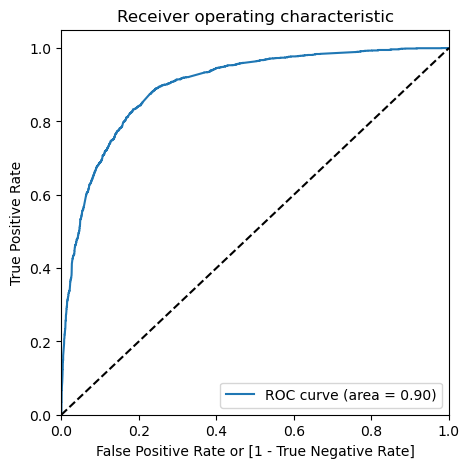

In [168]:
draw_roc(y_train_pred_df.converted, y_train_pred_df.converted_probability)

In [169]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_df[i]= y_train_pred_df.converted_probability.map(lambda x: 1 if x > i else 0)
y_train_pred_df.head()

,lead_index,converted,converted_probability,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,532,0,0.087410,0,1,0,0,0,0,0,0,0,0,0
1,7273,1,0.610311,1,1,1,1,1,1,1,1,0,0,0
2,4998,0,0.025431,0,1,0,0,0,0,0,0,0,0,0
3,6668,0,0.231041,0,1,1,1,0,0,0,0,0,0,0
4,2917,0,0.177114,0,1,1,0,0,0,0,0,0,0,0


In [170]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_df.converted, y_train_pred_df[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensitivity,specificity]
print(cutoff_df)

     prob  accuracy  sensitivity  specificity
0.0   0.0  0.378795     1.000000     0.000000
0.1   0.1  0.640949     0.972843     0.438568
0.2   0.2  0.782811     0.911958     0.704060
0.3   0.3  0.814004     0.850197     0.791934
0.4   0.4  0.822300     0.782742     0.846421
0.5   0.5  0.822134     0.720105     0.884348
0.6   0.6  0.815331     0.641261     0.921474
0.7   0.7  0.792600     0.534385     0.950053
0.8   0.8  0.768707     0.444590     0.966346
0.9   0.9  0.725734     0.299606     0.985577


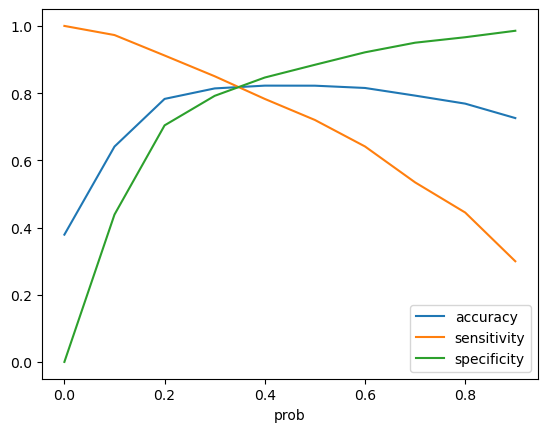

In [171]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

### From the above curve, we can infer that 0.35 would be optimal cut-off probability

In [173]:
givespace()

### 7.2 Precision Recall Curve

In [175]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score

def plot_precision_recall_curve(y_true, y_scores):
    
    # Convert probabilities to binary predictions
    threshold = 0.5
    y_pred = (y_scores >= threshold).astype(int)
    
    # Calculate metrics
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    
    # Precision-Recall Curve
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure(figsize=(8, 6))
    plt.plot(recalls, precisions, marker='.', label="Precision-Recall Curve")
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.legend()
    plt.show()
    
    # Find optimal threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"Optimal Threshold: {optimal_threshold:.2f}")
    print(f"Precision at Optimal Threshold: {precisions[optimal_idx]:.2f}")
    print(f"Recall at Optimal Threshold: {recalls[optimal_idx]:.2f}")
    print(f"F1-Score at Optimal Threshold: {f1_scores[optimal_idx]:.2f}")


Precision: 0.79
Recall: 0.72
F1-Score: 0.75


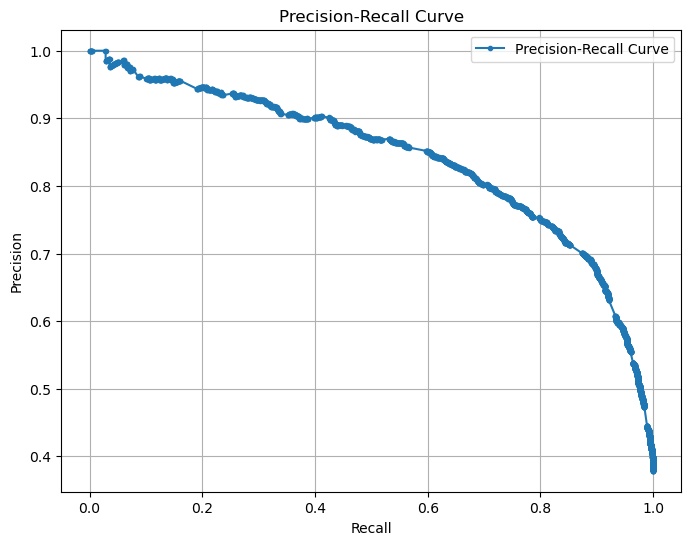

Optimal Threshold: 0.34
Precision at Optimal Threshold: 0.73
Recall at Optimal Threshold: 0.83
F1-Score at Optimal Threshold: 0.78


In [176]:
plot_precision_recall_curve(y_train, y_train_pred)

### Since for this model False Negative would be costly for a company where they lose the potential lead. We need to give priority to Recall or Sensitivity metric.

### From the above curve, we can infer that 0.34 would be optimal cut-off probability

In [179]:
y_train_pred_df['predicted'] = y_train_pred_df.converted_probability.map(lambda x: 1 if x > 0.34 else 0)
y_train_pred_df.head()

,lead_index,converted,converted_probability,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,532,0,0.087410,0,1,0,0,0,0,0,0,0,0,0
1,7273,1,0.610311,1,1,1,1,1,1,1,1,0,0,0
2,4998,0,0.025431,0,1,0,0,0,0,0,0,0,0,0
3,6668,0,0.231041,0,1,1,1,0,0,0,0,0,0,0
4,2917,0,0.177114,0,1,1,0,0,0,0,0,0,0,0


### 7.3: Training Dataset Metrics

In [181]:
get_model_metrics_using_confusion_matrix( y_train_pred_df.converted, y_train_pred_df.predicted )

[[3039  705]
 [ 381 1902]]


,Metric Name,Value
0,Accuracy,81.98
1,Sensitivity/Recall,83.31
2,Specificity,81.17
3,Precision,72.96
4,Positive Predictive Value,72.96
5,Negative Predictive Value,88.86


In [182]:
y_train_pred_df['Lead_Score'] = y_train_pred_df.converted_probability.map( lambda x: round(x*100))

y_train_pred_df.head()

,lead_index,converted,converted_probability,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,Lead_Score
0,532,0,0.087410,0,1,0,0,0,0,0,0,0,0,0,9
1,7273,1,0.610311,1,1,1,1,1,1,1,1,0,0,0,61
2,4998,0,0.025431,0,1,0,0,0,0,0,0,0,0,0,3
3,6668,0,0.231041,0,1,1,1,0,0,0,0,0,0,0,23
4,2917,0,0.177114,0,1,1,0,0,0,0,0,0,0,0,18


## 8. Predictions on Test Dataset

In [184]:
X_test[['total_visits', 'time_spend_website', 'page_views_per_visit']] = scaler.transform(X_test[['total_visits', 'time_spend_website', 'page_views_per_visit']])


In [185]:
# Assigning the features_selected columns of final model to the X_test 
X_test = X_test[features_selected]
X_test.head()

,email_unsubscribe,total_visits,time_spend_website,page_views_per_visit,subscribe_master_interview,lead_origin_Landing Page Submission,lead_origin_Lead Add Form,lead_source_Olark Chat,country_Others,specialization_Unknown,curr_occupation_Student,curr_occupation_Unemployed,curr_occupation_Working Professional,last_notable_activity_Email Opened,last_notable_activity_Olark Chat Conversation,last_notable_activity_Others,last_notable_activity_SMS Sent
376,0,0.538134,-0.184951,1.180749,0,1,0,0,0,0,0,0,0,0,0,0,0
8914,0,-0.326064,-0.866444,-0.040895,1,1,0,0,0,0,0,1,0,1,0,0,0
7331,0,0.106035,-0.210737,0.569927,0,1,0,0,0,0,0,1,0,1,0,0,0
6344,0,-0.326064,1.124622,-0.040895,1,1,0,0,0,0,0,0,0,1,0,0,0
3783,0,2.698630,-0.126011,0.569927,0,1,0,0,0,0,0,1,0,0,0,0,0


In [186]:
X_test_sm = sm.add_constant(X_test)

# Making predictions on the test set
y_test_pred = result.predict(X_test_sm)
y_test_pred[:10]

376     0.051726
8914    0.107278
7331    0.238022
6344    0.249126
3783    0.265977
4783    0.365640
3789    0.364115
185     0.667818
4116    0.897776
8622    0.049342
dtype: float64

In [187]:
# Converting y_test_pred to a dataframe which is an array
y_test_pred_df = pd.DataFrame(y_test_pred)

In [188]:
y_test_df = pd.DataFrame(y_test)

In [189]:
y_test_df['lead_index'] = y_test_df.index

In [190]:
# Removing index for both dataframes to append them side by side 
y_test_pred_df.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [191]:
# Appending y_test_df and y_pred_1
y_test_pred_df = pd.concat([y_test_df, y_test_pred_df],axis=1)
y_test_pred_df.head()

,converted,lead_index,0
0,0,376,0.051726
1,0,8914,0.107278
2,0,7331,0.238022
3,1,6344,0.249126
4,0,3783,0.265977


In [192]:
# Renaming the column 
y_test_pred_df= y_test_pred_df.rename(columns={ 0 : 'converted_probability'})
y_test_pred_df = y_test_pred_df.reindex(columns=['lead_index','converted','converted_probability'])
y_test_pred_df.head()

,lead_index,converted,converted_probability
0,376,0,0.051726
1,8914,0,0.107278
2,7331,0,0.238022
3,6344,1,0.249126
4,3783,0,0.265977


In [193]:
y_test_pred_df['predicted'] = y_test_pred_df.converted_probability.map(lambda x: 1 if x > 0.34 else 0)
y_test_pred_df.head()

,lead_index,converted,converted_probability,predicted
0,376,0,0.051726,0
1,8914,0,0.107278,0
2,7331,0,0.238022,0
3,6344,1,0.249126,0
4,3783,0,0.265977,0


### 8.1  Testing Dataset Metrics

In [195]:
get_model_metrics_using_confusion_matrix(y_test_pred_df.converted, y_test_pred_df.predicted)

[[1236  340]
 [ 187  821]]


,Metric Name,Value
0,Accuracy,79.61
1,Sensitivity/Recall,81.45
2,Specificity,78.43
3,Precision,70.71
4,Positive Predictive Value,70.71
5,Negative Predictive Value,86.86


In [196]:
y_test_pred_df['Lead_Score'] = y_test_pred_df.converted_probability.map( lambda x: round(x*100))
y_test_pred_df.head()

,lead_index,converted,converted_probability,predicted,Lead_Score
0,376,0,0.051726,0,5
1,8914,0,0.107278,0,11
2,7331,0,0.238022,0,24
3,6344,1,0.249126,0,25
4,3783,0,0.265977,0,27


In [197]:
len(y_train_pred_df[y_train_pred_df['Lead_Score']>80]) / len(y_train_pred_df)

0.18682594989215198

In [198]:
givespace()

## 9. Summary

- We have successfully built the model on train dataset and predicted on test dataset.
- Sensitiviy/Recall value gets priority over Precision value, as we need fewer False Negatives for this model. So that we would not miss the potential lead who is falsely identified as Negative.
- The model's evaluation against Training Dataset and Testing Dataset is as shown below

| Metric Name | Training Dataset | Testing Dataset |
|------------------|-----------------|-----------------|
| Accuracy    | 81.98    | 79.61   |
| Sensivity/Recall  | 83.31    | 81.45    |
| Specificity    | 81.17    | 78.43   |
| Precision    | 72.96    | 70.71    |

- There are around **19%** of the population identified as **Hot Lead** who have higher conversion rate.

In [201]:
givespace()

## 10. Recommendations

- Engage with **Working Professionals** as they need to upskill time on time and there is a high conversion rate.
- Analyze lead behavior who originated from **Lead Add Form** and who **spends more time on website**.
- Communicate the leads sourcing from **Welingak Websites** and **Reference** as these are more likely to get converted.
- Understand the **Student’s** or **Unemployed** people’s background and recommend the course which adds value to them.  Offer free counselling with mentors which convinces customer to opt for course.
- Automate **e-mail and SMS subscription** for the leads by sending the course brochure and curriculum. This interests customer to opt for the course.
- Target customers having **Lead Score** above **80** by rolling out special discounts or encouraging them to opt for higher end products.
